In [1]:
import torch
import torchvision.models as models

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl.gz'

In [3]:
path = Path('/home/molly/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
x_activation_set = x_train.clone()[:24960, :]

train_mean, train_std = x_train.mean(),x_train.std()
print(train_mean)
print(train_std)

tensor(0.1304)
tensor(0.3073)


In [6]:
def normalize(x, mean, std):
    return (x - mean) / std

In [7]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
x_activation_set = normalize(x_activation_set, train_mean, train_std)

In [8]:
print(f'train mean: {x_train.mean()} std: {x_train.std()}')
print(f'x_valid mean: {x_valid.mean()} std: {x_valid.std()}')
print(f'x_activation_set mean: {x_activation_set.mean()} std: {x_activation_set.std()}')

train mean: -3.046576011911384e-06 std: 1.0
x_valid mean: -0.005850573536008596 std: 0.9924333095550537
x_activation_set mean: 0.003005371429026127 std: 1.0038951635360718


In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

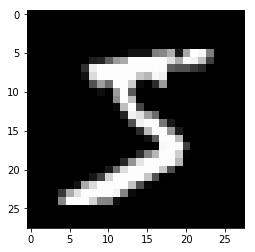

In [11]:
plt.imshow(img.view((28,28)));

In [12]:
print(y_train[0].item())

5


In [13]:
class ELUNet(torch.nn.Module):
    def __init__(self):
        super(ELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.elu

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        x = F.elu(self.fc6(x))
        x = F.elu(self.fc7(x))
        x = self.fc8(x)

        return F.log_softmax(x, dim=1)

class RELUNet(torch.nn.Module):
    def __init__(self):
        super(RELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.relu
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)
    
class LeakyRELUNet(torch.nn.Module):
    def __init__(self):
        super(LeakyRELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.leaky_relu
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc6(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc7(x), negative_slope=0.1)
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)
    
class BiasedRELUNet(torch.nn.Module):
    @staticmethod
    def biased_relu(x): 
        return x.clamp_min(0.) - 0.5
    
    def __init__(self):
        super(BiasedRELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = BiasedRELUNet.biased_relu
        
    def forward(self, x):
        x = BiasedRELUNet.biased_relu(self.fc1(x))
        x = BiasedRELUNet.biased_relu(self.fc2(x))
        x = BiasedRELUNet.biased_relu(self.fc3(x))
        x = BiasedRELUNet.biased_relu(self.fc4(x))
        x = BiasedRELUNet.biased_relu(self.fc5(x))
        x = BiasedRELUNet.biased_relu(self.fc6(x))
        x = BiasedRELUNet.biased_relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % (len(train_loader) // 4) == 0:
            # pulling mini-batch progress into its own string for easier formatting.
            batch_string = (f'[{batch_idx * len(data)}/{len(train_loader.dataset)}'
                            f'({100. * batch_idx / len(train_loader):.0f}%)]')
                
            print(f'Train Epoch: {epoch:<3} {batch_string:<20} Loss: {loss.item():.6f}')



In [15]:
def total_loss(model, device, loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(loader.dataset)
    
    return {'loss'        : loss,
            'num_correct' : correct}

In [16]:
def test(model, device, test_loader, train_loader):
    
    test_results = total_loss(model, device, test_loader)
    train_results = total_loss(model, device, train_loader)
    
    test_loss = test_results['loss']
    test_correct = test_results['num_correct']

    train_loss = train_results['loss']
    train_correct = train_results['num_correct']
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {test_correct}/{len(test_loader.dataset)} ({100. * test_correct / len(test_loader.dataset):.0f}%)\n')
    print(f'Train set: Average loss: {train_loss:.4f}, '
      f'Accuracy: {train_correct}/{len(train_loader.dataset)} ({100. * train_correct / len(train_loader.dataset):.0f}%)\n')
    
    return {'test_loss'  : test_loss, 
            'train_loss' : train_loss}

In [17]:
def mean_activation(model, device, activation_test_loader):
    model.eval()
    mean_activations = 0.0
    norm_factor = 1. / 8.
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        
        return hook
    
    with torch.no_grad():
        # Add hooks for computing average activation.
        fc1_handle = model.fc1.register_forward_hook(get_activation('fc1'))
        fc2_handle = model.fc2.register_forward_hook(get_activation('fc2'))
        fc3_handle = model.fc3.register_forward_hook(get_activation('fc3'))
        fc4_handle = model.fc4.register_forward_hook(get_activation('fc4'))
        fc5_handle = model.fc5.register_forward_hook(get_activation('fc5'))
        fc6_handle = model.fc6.register_forward_hook(get_activation('fc6'))
        fc7_handle = model.fc7.register_forward_hook(get_activation('fc7'))
        fc8_handle = model.fc8.register_forward_hook(get_activation('fc8'))

        for x in activation_test_loader:
            data = x[0].to(device)

            output = model(data)

            for element in activations:    
                #print(f"elementShape: {activations[element].shape}")
                activation_fn = model.activation_fn

                if activation_fn == F.leaky_relu:
                    mean_activations += activation_fn(activations[element], negative_slope=0.1).mean().item() * norm_factor
                else:
                    mean_activations += activation_fn(activations[element]).mean().item() * norm_factor

        mean_activations /= len(activation_test_loader)

        fc1_handle.remove()
        fc2_handle.remove()
        fc3_handle.remove()
        fc4_handle.remove()
        fc5_handle.remove()
        fc6_handle.remove()
        fc7_handle.remove()
        fc8_handle.remove()

    print(f"mean activation: {mean_activations:.4f}")
        
    return mean_activations

In [18]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [19]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
activation_test_dataset = torch.utils.data.TensorDataset(x_activation_set)

In [ ]:
t_model = None
t_model = RELUNet()

for params in t_model.parameters():
    if params.data.dim() == 2:
        print(f'Before - mean: {params.mean()}, std: {params.std()}')


t_model = t_model.apply(init_weights)
print('-----------------------------------------------------------------------------')

total_std = 0
for params in t_model.parameters():
    if params.data.dim() == 2:
        total_std += params.std()
        print(f'After - mean: {params.mean()}, std: {params.std()}')
#         print(params)

print(f'total stdev = {total_std}')

In [20]:
t_model = None
t_model = RELUNet()

for params in t_model.parameters():
    if params.data.dim() == 2:
        print(f'Before - mean: {params.mean()}, std: {params.std()}')


t_model = t_model.apply(init_weights)
print('-----------------------------------------------------------------------------')

total_std = 0
for params in t_model.parameters():
    if params.data.dim() == 2:
        total_std += params.std()
        print(f'After - mean: {params.mean()}, std: {params.std()}')
#         print(params)

print(f'total stdev = {total_std}')

Before - mean: -4.8895944928517565e-05, std: 0.020603805780410767
Before - mean: 6.248730642255396e-05, std: 0.05106780678033829
Before - mean: 8.727589738555253e-05, std: 0.0510568730533123
Before - mean: -8.473220805171877e-05, std: 0.05064833536744118
Before - mean: 0.00011764718510676175, std: 0.05095711722970009
Before - mean: -0.0005097667453810573, std: 0.05130404233932495
Before - mean: 0.0004214861255604774, std: 0.0510396771132946
Before - mean: 0.0011207407806068659, std: 0.0512540265917778
-----------------------------------------------------------------------------
After - mean: -8.914184581954032e-05, std: 0.05054164677858353
After - mean: -0.00020475810742937028, std: 0.1254897564649582
After - mean: 0.0009233033051714301, std: 0.12463843077421188
After - mean: -0.00016600522212684155, std: 0.12453616410493851
After - mean: -0.00022030080435797572, std: 0.12449447065591812
After - mean: -0.0006921756430529058, std: 0.12522543966770172
After - mean: 0.0015387485036626458,

In [21]:
test_results = []

for test_idx in range(0, 5):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,**kwargs)

    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=64, 
                                              shuffle=True, 
                                              **kwargs)

    activation_test_loader = torch.utils.data.DataLoader(activation_test_dataset, 
                                                         batch_size=256, 
                                                         shuffle=False, 
                                                         **kwargs)
    
    models = [BiasedRELUNet(), ELUNet(), RELUNet(), LeakyRELUNet()]
    result = []

    for idx, model in enumerate(models):
        model = model.to(device)
        model.apply(init_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

        result.append({'avg_activations'       : [],
                        'losses'                : []})

        for epoch in range(1, 125 + 1):
            train(model, device, train_loader, optimizer, epoch)

            avg_activation = mean_activation(model, device, activation_test_loader)
            losses = test(model, device, test_loader, train_loader)

            result[idx]['avg_activations'].append(avg_activation)
            result[idx]['losses'].append(losses)
     
    test_results.append(result)

/home/molly/anaconda3/envs/fastai_new/lib/python3.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 550 Ti which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Train Epoch: 1   [0/50000(0%)]        Loss: 2.449338
Train Epoch: 1   [12480/50000(25%)]   Loss: 0.456518
Train Epoch: 1   [24960/50000(50%)]   Loss: 0.210180
Train Epoch: 1   [37440/50000(75%)]   Loss: 0.185663
Train Epoch: 1   [49920/50000(100%)]  Loss: 0.214560
mean activation: 0.3399

Test set: Average loss: 0.2164, Accuracy: 9339/10000 (93%)

Train set: Average loss: 0.2142, Accuracy: 46778/50000 (94%)

Train Epoch: 2   [0/50000(0%)]        Loss: 0.269797
Train Epoch: 2   [12480/50000(25%)]   Loss: 0.270378
Train Epoch: 2   [24960/50000(50%)]   Loss: 0.130646
Train Epoch: 2   [37440/50000(75%)]   Loss: 0.170840
Train Epoch: 2   [49920/50000(100%)]  Loss: 0.059915
mean activation: 0.4030

Test set: Average loss: 0.1911, Accuracy: 9397/10000 (94%)

Train set: Average loss: 0.1757, Accuracy: 47175/50000 (94%)

Train Epoch: 3   [0/50000(0%)]        Loss: 0.100200
Train Epoch: 3   [12480/50000(25%)]   Loss: 0.026948
Train Epoch: 3   [24960/50000(50%)]   Loss: 0.341948
Train Epoch: 3   

Train Epoch: 21  [0/50000(0%)]        Loss: 0.000465
Train Epoch: 21  [12480/50000(25%)]   Loss: 0.002118
Train Epoch: 21  [24960/50000(50%)]   Loss: 0.003198
Train Epoch: 21  [37440/50000(75%)]   Loss: 0.000959
Train Epoch: 21  [49920/50000(100%)]  Loss: 0.001907
mean activation: 0.8987

Test set: Average loss: 0.1452, Accuracy: 9689/10000 (97%)

Train set: Average loss: 0.0024, Accuracy: 49996/50000 (100%)

Train Epoch: 22  [0/50000(0%)]        Loss: 0.000950
Train Epoch: 22  [12480/50000(25%)]   Loss: 0.001563
Train Epoch: 22  [24960/50000(50%)]   Loss: 0.000893
Train Epoch: 22  [37440/50000(75%)]   Loss: 0.002581
Train Epoch: 22  [49920/50000(100%)]  Loss: 0.002059
mean activation: 0.9166

Test set: Average loss: 0.1451, Accuracy: 9690/10000 (97%)

Train set: Average loss: 0.0020, Accuracy: 49998/50000 (100%)

Train Epoch: 23  [0/50000(0%)]        Loss: 0.002685
Train Epoch: 23  [12480/50000(25%)]   Loss: 0.001655
Train Epoch: 23  [24960/50000(50%)]   Loss: 0.000350
Train Epoch: 23

Train Epoch: 41  [0/50000(0%)]        Loss: 0.000410
Train Epoch: 41  [12480/50000(25%)]   Loss: 0.000547
Train Epoch: 41  [24960/50000(50%)]   Loss: 0.000072
Train Epoch: 41  [37440/50000(75%)]   Loss: 0.000707
Train Epoch: 41  [49920/50000(100%)]  Loss: 0.000083
mean activation: 1.1175

Test set: Average loss: 0.1735, Accuracy: 9694/10000 (97%)

Train set: Average loss: 0.0005, Accuracy: 50000/50000 (100%)

Train Epoch: 42  [0/50000(0%)]        Loss: 0.000579
Train Epoch: 42  [12480/50000(25%)]   Loss: 0.000570
Train Epoch: 42  [24960/50000(50%)]   Loss: 0.000448
Train Epoch: 42  [37440/50000(75%)]   Loss: 0.000514
Train Epoch: 42  [49920/50000(100%)]  Loss: 0.000940
mean activation: 1.1232

Test set: Average loss: 0.1738, Accuracy: 9695/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 43  [0/50000(0%)]        Loss: 0.000313
Train Epoch: 43  [12480/50000(25%)]   Loss: 0.000087
Train Epoch: 43  [24960/50000(50%)]   Loss: 0.000286
Train Epoch: 43

Train Epoch: 61  [0/50000(0%)]        Loss: 0.000499
Train Epoch: 61  [12480/50000(25%)]   Loss: 0.000043
Train Epoch: 61  [24960/50000(50%)]   Loss: 0.000068
Train Epoch: 61  [37440/50000(75%)]   Loss: 0.000112
Train Epoch: 61  [49920/50000(100%)]  Loss: 0.000206
mean activation: 1.2105

Test set: Average loss: 0.1863, Accuracy: 9698/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 62  [0/50000(0%)]        Loss: 0.000188
Train Epoch: 62  [12480/50000(25%)]   Loss: 0.000154
Train Epoch: 62  [24960/50000(50%)]   Loss: 0.000354
Train Epoch: 62  [37440/50000(75%)]   Loss: 0.000085
Train Epoch: 62  [49920/50000(100%)]  Loss: 0.000279
mean activation: 1.2103

Test set: Average loss: 0.1863, Accuracy: 9700/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 63  [0/50000(0%)]        Loss: 0.000070
Train Epoch: 63  [12480/50000(25%)]   Loss: 0.000644
Train Epoch: 63  [24960/50000(50%)]   Loss: 0.000056
Train Epoch: 63

Train Epoch: 81  [0/50000(0%)]        Loss: 0.000123
Train Epoch: 81  [12480/50000(25%)]   Loss: 0.000612
Train Epoch: 81  [24960/50000(50%)]   Loss: 0.000069
Train Epoch: 81  [37440/50000(75%)]   Loss: 0.000338
Train Epoch: 81  [49920/50000(100%)]  Loss: 0.000063
mean activation: 1.2686

Test set: Average loss: 0.1955, Accuracy: 9697/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 82  [0/50000(0%)]        Loss: 0.000149
Train Epoch: 82  [12480/50000(25%)]   Loss: 0.000056
Train Epoch: 82  [24960/50000(50%)]   Loss: 0.000250
Train Epoch: 82  [37440/50000(75%)]   Loss: 0.000249
Train Epoch: 82  [49920/50000(100%)]  Loss: 0.000488
mean activation: 1.2702

Test set: Average loss: 0.1958, Accuracy: 9695/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 83  [0/50000(0%)]        Loss: 0.000180
Train Epoch: 83  [12480/50000(25%)]   Loss: 0.000330
Train Epoch: 83  [24960/50000(50%)]   Loss: 0.000056
Train Epoch: 83

Train Epoch: 101 [0/50000(0%)]        Loss: 0.000211
Train Epoch: 101 [12480/50000(25%)]   Loss: 0.000034
Train Epoch: 101 [24960/50000(50%)]   Loss: 0.000143
Train Epoch: 101 [37440/50000(75%)]   Loss: 0.000140
Train Epoch: 101 [49920/50000(100%)]  Loss: 0.000039
mean activation: 1.3116

Test set: Average loss: 0.2019, Accuracy: 9698/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 102 [0/50000(0%)]        Loss: 0.000035
Train Epoch: 102 [12480/50000(25%)]   Loss: 0.000183
Train Epoch: 102 [24960/50000(50%)]   Loss: 0.000016
Train Epoch: 102 [37440/50000(75%)]   Loss: 0.000097
Train Epoch: 102 [49920/50000(100%)]  Loss: 0.000310
mean activation: 1.3122

Test set: Average loss: 0.2018, Accuracy: 9697/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 103 [0/50000(0%)]        Loss: 0.000050
Train Epoch: 103 [12480/50000(25%)]   Loss: 0.000125
Train Epoch: 103 [24960/50000(50%)]   Loss: 0.000156
Train Epoch: 10

Train Epoch: 121 [0/50000(0%)]        Loss: 0.000111
Train Epoch: 121 [12480/50000(25%)]   Loss: 0.000051
Train Epoch: 121 [24960/50000(50%)]   Loss: 0.000027
Train Epoch: 121 [37440/50000(75%)]   Loss: 0.000020
Train Epoch: 121 [49920/50000(100%)]  Loss: 0.000064
mean activation: 1.3451

Test set: Average loss: 0.2070, Accuracy: 9698/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 122 [0/50000(0%)]        Loss: 0.000088
Train Epoch: 122 [12480/50000(25%)]   Loss: 0.000100
Train Epoch: 122 [24960/50000(50%)]   Loss: 0.000045
Train Epoch: 122 [37440/50000(75%)]   Loss: 0.000078
Train Epoch: 122 [49920/50000(100%)]  Loss: 0.000142
mean activation: 1.3470

Test set: Average loss: 0.2072, Accuracy: 9698/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 123 [0/50000(0%)]        Loss: 0.000012
Train Epoch: 123 [12480/50000(25%)]   Loss: 0.000052
Train Epoch: 123 [24960/50000(50%)]   Loss: 0.000037
Train Epoch: 12

Train Epoch: 16  [0/50000(0%)]        Loss: 0.009118
Train Epoch: 16  [12480/50000(25%)]   Loss: 0.001776
Train Epoch: 16  [24960/50000(50%)]   Loss: 0.001313
Train Epoch: 16  [37440/50000(75%)]   Loss: 0.005626
Train Epoch: 16  [49920/50000(100%)]  Loss: 0.005127
mean activation: 1.2006

Test set: Average loss: 0.1253, Accuracy: 9709/10000 (97%)

Train set: Average loss: 0.0061, Accuracy: 49963/50000 (100%)

Train Epoch: 17  [0/50000(0%)]        Loss: 0.002050
Train Epoch: 17  [12480/50000(25%)]   Loss: 0.001232
Train Epoch: 17  [24960/50000(50%)]   Loss: 0.006623
Train Epoch: 17  [37440/50000(75%)]   Loss: 0.106132
Train Epoch: 17  [49920/50000(100%)]  Loss: 0.003531
mean activation: 1.2396

Test set: Average loss: 0.1221, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0043, Accuracy: 49988/50000 (100%)

Train Epoch: 18  [0/50000(0%)]        Loss: 0.005296
Train Epoch: 18  [12480/50000(25%)]   Loss: 0.005029
Train Epoch: 18  [24960/50000(50%)]   Loss: 0.005773
Train Epoch: 18

Train Epoch: 36  [0/50000(0%)]        Loss: 0.000320
Train Epoch: 36  [12480/50000(25%)]   Loss: 0.002893
Train Epoch: 36  [24960/50000(50%)]   Loss: 0.002891
Train Epoch: 36  [37440/50000(75%)]   Loss: 0.000252
Train Epoch: 36  [49920/50000(100%)]  Loss: 0.000563
mean activation: 1.5824

Test set: Average loss: 0.1494, Accuracy: 9734/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 37  [0/50000(0%)]        Loss: 0.000543
Train Epoch: 37  [12480/50000(25%)]   Loss: 0.000175
Train Epoch: 37  [24960/50000(50%)]   Loss: 0.000979
Train Epoch: 37  [37440/50000(75%)]   Loss: 0.000478
Train Epoch: 37  [49920/50000(100%)]  Loss: 0.000449
mean activation: 1.5871

Test set: Average loss: 0.1515, Accuracy: 9739/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 49999/50000 (100%)

Train Epoch: 38  [0/50000(0%)]        Loss: 0.001481
Train Epoch: 38  [12480/50000(25%)]   Loss: 0.000414
Train Epoch: 38  [24960/50000(50%)]   Loss: 0.000617
Train Epoch: 38

Train Epoch: 56  [0/50000(0%)]        Loss: 0.000209
Train Epoch: 56  [12480/50000(25%)]   Loss: 0.000089
Train Epoch: 56  [24960/50000(50%)]   Loss: 0.000206
Train Epoch: 56  [37440/50000(75%)]   Loss: 0.000271
Train Epoch: 56  [49920/50000(100%)]  Loss: 0.000316
mean activation: 1.7277

Test set: Average loss: 0.1631, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 57  [0/50000(0%)]        Loss: 0.000065
Train Epoch: 57  [12480/50000(25%)]   Loss: 0.000524
Train Epoch: 57  [24960/50000(50%)]   Loss: 0.000218
Train Epoch: 57  [37440/50000(75%)]   Loss: 0.000252
Train Epoch: 57  [49920/50000(100%)]  Loss: 0.000277
mean activation: 1.7361

Test set: Average loss: 0.1642, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 58  [0/50000(0%)]        Loss: 0.000130
Train Epoch: 58  [12480/50000(25%)]   Loss: 0.000295
Train Epoch: 58  [24960/50000(50%)]   Loss: 0.000088
Train Epoch: 58

Train Epoch: 76  [0/50000(0%)]        Loss: 0.000337
Train Epoch: 76  [12480/50000(25%)]   Loss: 0.000289
Train Epoch: 76  [24960/50000(50%)]   Loss: 0.000048
Train Epoch: 76  [37440/50000(75%)]   Loss: 0.000259
Train Epoch: 76  [49920/50000(100%)]  Loss: 0.000042
mean activation: 1.8200

Test set: Average loss: 0.1720, Accuracy: 9745/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 77  [0/50000(0%)]        Loss: 0.000651
Train Epoch: 77  [12480/50000(25%)]   Loss: 0.000310
Train Epoch: 77  [24960/50000(50%)]   Loss: 0.000132
Train Epoch: 77  [37440/50000(75%)]   Loss: 0.000376
Train Epoch: 77  [49920/50000(100%)]  Loss: 0.000243
mean activation: 1.8231

Test set: Average loss: 0.1722, Accuracy: 9747/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 78  [0/50000(0%)]        Loss: 0.000254
Train Epoch: 78  [12480/50000(25%)]   Loss: 0.000104
Train Epoch: 78  [24960/50000(50%)]   Loss: 0.000028
Train Epoch: 78

Train Epoch: 96  [0/50000(0%)]        Loss: 0.000077
Train Epoch: 96  [12480/50000(25%)]   Loss: 0.000234
Train Epoch: 96  [24960/50000(50%)]   Loss: 0.000098
Train Epoch: 96  [37440/50000(75%)]   Loss: 0.000207
Train Epoch: 96  [49920/50000(100%)]  Loss: 0.000112
mean activation: 1.8851

Test set: Average loss: 0.1783, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 97  [0/50000(0%)]        Loss: 0.000027
Train Epoch: 97  [12480/50000(25%)]   Loss: 0.000061
Train Epoch: 97  [24960/50000(50%)]   Loss: 0.000273
Train Epoch: 97  [37440/50000(75%)]   Loss: 0.000152
Train Epoch: 97  [49920/50000(100%)]  Loss: 0.000181
mean activation: 1.8877

Test set: Average loss: 0.1786, Accuracy: 9744/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 98  [0/50000(0%)]        Loss: 0.000035
Train Epoch: 98  [12480/50000(25%)]   Loss: 0.000135
Train Epoch: 98  [24960/50000(50%)]   Loss: 0.000053
Train Epoch: 98

Train Epoch: 116 [0/50000(0%)]        Loss: 0.000082
Train Epoch: 116 [12480/50000(25%)]   Loss: 0.000107
Train Epoch: 116 [24960/50000(50%)]   Loss: 0.000157
Train Epoch: 116 [37440/50000(75%)]   Loss: 0.000142
Train Epoch: 116 [49920/50000(100%)]  Loss: 0.000068
mean activation: 1.9358

Test set: Average loss: 0.1835, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 117 [0/50000(0%)]        Loss: 0.000133
Train Epoch: 117 [12480/50000(25%)]   Loss: 0.000073
Train Epoch: 117 [24960/50000(50%)]   Loss: 0.000141
Train Epoch: 117 [37440/50000(75%)]   Loss: 0.000095
Train Epoch: 117 [49920/50000(100%)]  Loss: 0.000081
mean activation: 1.9384

Test set: Average loss: 0.1836, Accuracy: 9746/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 118 [0/50000(0%)]        Loss: 0.000139
Train Epoch: 118 [12480/50000(25%)]   Loss: 0.000115
Train Epoch: 118 [24960/50000(50%)]   Loss: 0.000013
Train Epoch: 11

Train Epoch: 11  [0/50000(0%)]        Loss: 0.012170
Train Epoch: 11  [12480/50000(25%)]   Loss: 0.042904
Train Epoch: 11  [24960/50000(50%)]   Loss: 0.053567
Train Epoch: 11  [37440/50000(75%)]   Loss: 0.038067
Train Epoch: 11  [49920/50000(100%)]  Loss: 0.019249
mean activation: 1.3997

Test set: Average loss: 0.1221, Accuracy: 9685/10000 (97%)

Train set: Average loss: 0.0272, Accuracy: 49606/50000 (99%)

Train Epoch: 12  [0/50000(0%)]        Loss: 0.044272
Train Epoch: 12  [12480/50000(25%)]   Loss: 0.003162
Train Epoch: 12  [24960/50000(50%)]   Loss: 0.024204
Train Epoch: 12  [37440/50000(75%)]   Loss: 0.066530
Train Epoch: 12  [49920/50000(100%)]  Loss: 0.175596
mean activation: 1.4518

Test set: Average loss: 0.1265, Accuracy: 9681/10000 (97%)

Train set: Average loss: 0.0241, Accuracy: 49656/50000 (99%)

Train Epoch: 13  [0/50000(0%)]        Loss: 0.004565
Train Epoch: 13  [12480/50000(25%)]   Loss: 0.006851
Train Epoch: 13  [24960/50000(50%)]   Loss: 0.006775
Train Epoch: 13  

Train Epoch: 31  [0/50000(0%)]        Loss: 0.001202
Train Epoch: 31  [12480/50000(25%)]   Loss: 0.000611
Train Epoch: 31  [24960/50000(50%)]   Loss: 0.000245
Train Epoch: 31  [37440/50000(75%)]   Loss: 0.000708
Train Epoch: 31  [49920/50000(100%)]  Loss: 0.000512
mean activation: 1.9238

Test set: Average loss: 0.1670, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0009, Accuracy: 50000/50000 (100%)

Train Epoch: 32  [0/50000(0%)]        Loss: 0.002874
Train Epoch: 32  [12480/50000(25%)]   Loss: 0.000639
Train Epoch: 32  [24960/50000(50%)]   Loss: 0.002675
Train Epoch: 32  [37440/50000(75%)]   Loss: 0.000386
Train Epoch: 32  [49920/50000(100%)]  Loss: 0.000820
mean activation: 1.9367

Test set: Average loss: 0.1669, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 33  [0/50000(0%)]        Loss: 0.001463
Train Epoch: 33  [12480/50000(25%)]   Loss: 0.000383
Train Epoch: 33  [24960/50000(50%)]   Loss: 0.000467
Train Epoch: 33

Train Epoch: 51  [0/50000(0%)]        Loss: 0.000549
Train Epoch: 51  [12480/50000(25%)]   Loss: 0.000456
Train Epoch: 51  [24960/50000(50%)]   Loss: 0.000286
Train Epoch: 51  [37440/50000(75%)]   Loss: 0.000169
Train Epoch: 51  [49920/50000(100%)]  Loss: 0.000487
mean activation: 2.0900

Test set: Average loss: 0.1855, Accuracy: 9726/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 52  [0/50000(0%)]        Loss: 0.000155
Train Epoch: 52  [12480/50000(25%)]   Loss: 0.000037
Train Epoch: 52  [24960/50000(50%)]   Loss: 0.000123
Train Epoch: 52  [37440/50000(75%)]   Loss: 0.000208
Train Epoch: 52  [49920/50000(100%)]  Loss: 0.000065
mean activation: 2.0941

Test set: Average loss: 0.1866, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 53  [0/50000(0%)]        Loss: 0.000341
Train Epoch: 53  [12480/50000(25%)]   Loss: 0.000511
Train Epoch: 53  [24960/50000(50%)]   Loss: 0.000429
Train Epoch: 53

Train Epoch: 71  [0/50000(0%)]        Loss: 0.000168
Train Epoch: 71  [12480/50000(25%)]   Loss: 0.000156
Train Epoch: 71  [24960/50000(50%)]   Loss: 0.000032
Train Epoch: 71  [37440/50000(75%)]   Loss: 0.000114
Train Epoch: 71  [49920/50000(100%)]  Loss: 0.000077
mean activation: 2.1815

Test set: Average loss: 0.1968, Accuracy: 9724/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 72  [0/50000(0%)]        Loss: 0.000255
Train Epoch: 72  [12480/50000(25%)]   Loss: 0.000220
Train Epoch: 72  [24960/50000(50%)]   Loss: 0.000190
Train Epoch: 72  [37440/50000(75%)]   Loss: 0.000093
Train Epoch: 72  [49920/50000(100%)]  Loss: 0.000123
mean activation: 2.1826

Test set: Average loss: 0.1976, Accuracy: 9729/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 73  [0/50000(0%)]        Loss: 0.000082
Train Epoch: 73  [12480/50000(25%)]   Loss: 0.000219
Train Epoch: 73  [24960/50000(50%)]   Loss: 0.000056
Train Epoch: 73

Train Epoch: 91  [0/50000(0%)]        Loss: 0.000172
Train Epoch: 91  [12480/50000(25%)]   Loss: 0.000020
Train Epoch: 91  [24960/50000(50%)]   Loss: 0.000053
Train Epoch: 91  [37440/50000(75%)]   Loss: 0.000093
Train Epoch: 91  [49920/50000(100%)]  Loss: 0.000082
mean activation: 2.2411

Test set: Average loss: 0.2054, Accuracy: 9726/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 92  [0/50000(0%)]        Loss: 0.000084
Train Epoch: 92  [12480/50000(25%)]   Loss: 0.000138
Train Epoch: 92  [24960/50000(50%)]   Loss: 0.000067
Train Epoch: 92  [37440/50000(75%)]   Loss: 0.000138
Train Epoch: 92  [49920/50000(100%)]  Loss: 0.000017
mean activation: 2.2438

Test set: Average loss: 0.2058, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 93  [0/50000(0%)]        Loss: 0.000294
Train Epoch: 93  [12480/50000(25%)]   Loss: 0.000320
Train Epoch: 93  [24960/50000(50%)]   Loss: 0.000080
Train Epoch: 93

Train Epoch: 111 [0/50000(0%)]        Loss: 0.000065
Train Epoch: 111 [12480/50000(25%)]   Loss: 0.000215
Train Epoch: 111 [24960/50000(50%)]   Loss: 0.000005
Train Epoch: 111 [37440/50000(75%)]   Loss: 0.000247
Train Epoch: 111 [49920/50000(100%)]  Loss: 0.000008
mean activation: 2.2876

Test set: Average loss: 0.2116, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 112 [0/50000(0%)]        Loss: 0.000176
Train Epoch: 112 [12480/50000(25%)]   Loss: 0.000048
Train Epoch: 112 [24960/50000(50%)]   Loss: 0.000083
Train Epoch: 112 [37440/50000(75%)]   Loss: 0.000015
Train Epoch: 112 [49920/50000(100%)]  Loss: 0.000019
mean activation: 2.2899

Test set: Average loss: 0.2119, Accuracy: 9729/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 113 [0/50000(0%)]        Loss: 0.000007
Train Epoch: 113 [12480/50000(25%)]   Loss: 0.000045
Train Epoch: 113 [24960/50000(50%)]   Loss: 0.000076
Train Epoch: 11

Train Epoch: 6   [0/50000(0%)]        Loss: 0.041473
Train Epoch: 6   [12480/50000(25%)]   Loss: 0.147554
Train Epoch: 6   [24960/50000(50%)]   Loss: 0.078643
Train Epoch: 6   [37440/50000(75%)]   Loss: 0.019411
Train Epoch: 6   [49920/50000(100%)]  Loss: 0.046572
mean activation: 1.0979

Test set: Average loss: 0.1138, Accuracy: 9667/10000 (97%)

Train set: Average loss: 0.0597, Accuracy: 49169/50000 (98%)

Train Epoch: 7   [0/50000(0%)]        Loss: 0.023380
Train Epoch: 7   [12480/50000(25%)]   Loss: 0.071909
Train Epoch: 7   [24960/50000(50%)]   Loss: 0.171289
Train Epoch: 7   [37440/50000(75%)]   Loss: 0.090047
Train Epoch: 7   [49920/50000(100%)]  Loss: 0.071660
mean activation: 1.1567

Test set: Average loss: 0.2258, Accuracy: 9319/10000 (93%)

Train set: Average loss: 0.1652, Accuracy: 47376/50000 (95%)

Train Epoch: 8   [0/50000(0%)]        Loss: 0.173826
Train Epoch: 8   [12480/50000(25%)]   Loss: 0.018922
Train Epoch: 8   [24960/50000(50%)]   Loss: 0.098405
Train Epoch: 8   

Train Epoch: 26  [0/50000(0%)]        Loss: 0.003708
Train Epoch: 26  [12480/50000(25%)]   Loss: 0.002821
Train Epoch: 26  [24960/50000(50%)]   Loss: 0.000248
Train Epoch: 26  [37440/50000(75%)]   Loss: 0.000322
Train Epoch: 26  [49920/50000(100%)]  Loss: 0.001074
mean activation: 1.5846

Test set: Average loss: 0.1343, Accuracy: 9750/10000 (98%)

Train set: Average loss: 0.0019, Accuracy: 49994/50000 (100%)

Train Epoch: 27  [0/50000(0%)]        Loss: 0.000846
Train Epoch: 27  [12480/50000(25%)]   Loss: 0.002011
Train Epoch: 27  [24960/50000(50%)]   Loss: 0.007708
Train Epoch: 27  [37440/50000(75%)]   Loss: 0.000462
Train Epoch: 27  [49920/50000(100%)]  Loss: 0.000480
mean activation: 1.6011

Test set: Average loss: 0.1368, Accuracy: 9735/10000 (97%)

Train set: Average loss: 0.0015, Accuracy: 49994/50000 (100%)

Train Epoch: 28  [0/50000(0%)]        Loss: 0.000304
Train Epoch: 28  [12480/50000(25%)]   Loss: 0.000705
Train Epoch: 28  [24960/50000(50%)]   Loss: 0.000405
Train Epoch: 28

Train Epoch: 46  [0/50000(0%)]        Loss: 0.000482
Train Epoch: 46  [12480/50000(25%)]   Loss: 0.000355
Train Epoch: 46  [24960/50000(50%)]   Loss: 0.000191
Train Epoch: 46  [37440/50000(75%)]   Loss: 0.000512
Train Epoch: 46  [49920/50000(100%)]  Loss: 0.000418
mean activation: 1.8016

Test set: Average loss: 0.1598, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 47  [0/50000(0%)]        Loss: 0.000136
Train Epoch: 47  [12480/50000(25%)]   Loss: 0.000720
Train Epoch: 47  [24960/50000(50%)]   Loss: 0.000471
Train Epoch: 47  [37440/50000(75%)]   Loss: 0.000143
Train Epoch: 47  [49920/50000(100%)]  Loss: 0.000216
mean activation: 1.8042

Test set: Average loss: 0.1598, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 48  [0/50000(0%)]        Loss: 0.000499
Train Epoch: 48  [12480/50000(25%)]   Loss: 0.000254
Train Epoch: 48  [24960/50000(50%)]   Loss: 0.000326
Train Epoch: 48

Train Epoch: 66  [0/50000(0%)]        Loss: 0.000142
Train Epoch: 66  [12480/50000(25%)]   Loss: 0.000142
Train Epoch: 66  [24960/50000(50%)]   Loss: 0.000013
Train Epoch: 66  [37440/50000(75%)]   Loss: 0.000091
Train Epoch: 66  [49920/50000(100%)]  Loss: 0.000176
mean activation: 1.8941

Test set: Average loss: 0.1713, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 67  [0/50000(0%)]        Loss: 0.000119
Train Epoch: 67  [12480/50000(25%)]   Loss: 0.000157
Train Epoch: 67  [24960/50000(50%)]   Loss: 0.000319
Train Epoch: 67  [37440/50000(75%)]   Loss: 0.000128
Train Epoch: 67  [49920/50000(100%)]  Loss: 0.000345
mean activation: 1.8982

Test set: Average loss: 0.1710, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 68  [0/50000(0%)]        Loss: 0.000356
Train Epoch: 68  [12480/50000(25%)]   Loss: 0.000212
Train Epoch: 68  [24960/50000(50%)]   Loss: 0.000110
Train Epoch: 68

Train Epoch: 86  [0/50000(0%)]        Loss: 0.000081
Train Epoch: 86  [12480/50000(25%)]   Loss: 0.000144
Train Epoch: 86  [24960/50000(50%)]   Loss: 0.000087
Train Epoch: 86  [37440/50000(75%)]   Loss: 0.000178
Train Epoch: 86  [49920/50000(100%)]  Loss: 0.000110
mean activation: 1.9536

Test set: Average loss: 0.1786, Accuracy: 9752/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 87  [0/50000(0%)]        Loss: 0.000026
Train Epoch: 87  [12480/50000(25%)]   Loss: 0.000026
Train Epoch: 87  [24960/50000(50%)]   Loss: 0.000090
Train Epoch: 87  [37440/50000(75%)]   Loss: 0.000132
Train Epoch: 87  [49920/50000(100%)]  Loss: 0.000083
mean activation: 1.9560

Test set: Average loss: 0.1803, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 88  [0/50000(0%)]        Loss: 0.000052
Train Epoch: 88  [12480/50000(25%)]   Loss: 0.000099
Train Epoch: 88  [24960/50000(50%)]   Loss: 0.000011
Train Epoch: 88

Train Epoch: 106 [0/50000(0%)]        Loss: 0.000026
Train Epoch: 106 [12480/50000(25%)]   Loss: 0.000012
Train Epoch: 106 [24960/50000(50%)]   Loss: 0.000079
Train Epoch: 106 [37440/50000(75%)]   Loss: 0.000036
Train Epoch: 106 [49920/50000(100%)]  Loss: 0.000126
mean activation: 1.9984

Test set: Average loss: 0.1852, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 107 [0/50000(0%)]        Loss: 0.000078
Train Epoch: 107 [12480/50000(25%)]   Loss: 0.000132
Train Epoch: 107 [24960/50000(50%)]   Loss: 0.000021
Train Epoch: 107 [37440/50000(75%)]   Loss: 0.000025
Train Epoch: 107 [49920/50000(100%)]  Loss: 0.000096
mean activation: 2.0006

Test set: Average loss: 0.1853, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 108 [0/50000(0%)]        Loss: 0.000121
Train Epoch: 108 [12480/50000(25%)]   Loss: 0.000063
Train Epoch: 108 [24960/50000(50%)]   Loss: 0.000051
Train Epoch: 10

Train Epoch: 1   [0/50000(0%)]        Loss: 2.446444
Train Epoch: 1   [12480/50000(25%)]   Loss: 0.790031
Train Epoch: 1   [24960/50000(50%)]   Loss: 0.279555
Train Epoch: 1   [37440/50000(75%)]   Loss: 0.253973
Train Epoch: 1   [49920/50000(100%)]  Loss: 0.329375
mean activation: 0.5959

Test set: Average loss: 0.2452, Accuracy: 9254/10000 (93%)

Train set: Average loss: 0.2483, Accuracy: 46138/50000 (92%)

Train Epoch: 2   [0/50000(0%)]        Loss: 0.188706
Train Epoch: 2   [12480/50000(25%)]   Loss: 0.074325
Train Epoch: 2   [24960/50000(50%)]   Loss: 0.131873
Train Epoch: 2   [37440/50000(75%)]   Loss: 0.069524
Train Epoch: 2   [49920/50000(100%)]  Loss: 0.184218
mean activation: 0.6143

Test set: Average loss: 0.1774, Accuracy: 9476/10000 (95%)

Train set: Average loss: 0.1612, Accuracy: 47539/50000 (95%)

Train Epoch: 3   [0/50000(0%)]        Loss: 0.309686
Train Epoch: 3   [12480/50000(25%)]   Loss: 0.096711
Train Epoch: 3   [24960/50000(50%)]   Loss: 0.255542
Train Epoch: 3   

Train Epoch: 21  [0/50000(0%)]        Loss: 0.007909
Train Epoch: 21  [12480/50000(25%)]   Loss: 0.000582
Train Epoch: 21  [24960/50000(50%)]   Loss: 0.000470
Train Epoch: 21  [37440/50000(75%)]   Loss: 0.002266
Train Epoch: 21  [49920/50000(100%)]  Loss: 0.009658
mean activation: 1.1283

Test set: Average loss: 0.1408, Accuracy: 9683/10000 (97%)

Train set: Average loss: 0.0050, Accuracy: 49973/50000 (100%)

Train Epoch: 22  [0/50000(0%)]        Loss: 0.013622
Train Epoch: 22  [12480/50000(25%)]   Loss: 0.004555
Train Epoch: 22  [24960/50000(50%)]   Loss: 0.001296
Train Epoch: 22  [37440/50000(75%)]   Loss: 0.002828
Train Epoch: 22  [49920/50000(100%)]  Loss: 0.004653
mean activation: 1.1452

Test set: Average loss: 0.1365, Accuracy: 9708/10000 (97%)

Train set: Average loss: 0.0037, Accuracy: 49984/50000 (100%)

Train Epoch: 23  [0/50000(0%)]        Loss: 0.002021
Train Epoch: 23  [12480/50000(25%)]   Loss: 0.001009
Train Epoch: 23  [24960/50000(50%)]   Loss: 0.003486
Train Epoch: 23

Train Epoch: 41  [0/50000(0%)]        Loss: 0.000609
Train Epoch: 41  [12480/50000(25%)]   Loss: 0.000349
Train Epoch: 41  [24960/50000(50%)]   Loss: 0.000376
Train Epoch: 41  [37440/50000(75%)]   Loss: 0.000242
Train Epoch: 41  [49920/50000(100%)]  Loss: 0.000439
mean activation: 1.4180

Test set: Average loss: 0.1617, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 49999/50000 (100%)

Train Epoch: 42  [0/50000(0%)]        Loss: 0.001012
Train Epoch: 42  [12480/50000(25%)]   Loss: 0.000151
Train Epoch: 42  [24960/50000(50%)]   Loss: 0.000192
Train Epoch: 42  [37440/50000(75%)]   Loss: 0.001032
Train Epoch: 42  [49920/50000(100%)]  Loss: 0.000928
mean activation: 1.4250

Test set: Average loss: 0.1624, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0005, Accuracy: 49999/50000 (100%)

Train Epoch: 43  [0/50000(0%)]        Loss: 0.000313
Train Epoch: 43  [12480/50000(25%)]   Loss: 0.000363
Train Epoch: 43  [24960/50000(50%)]   Loss: 0.000556
Train Epoch: 43

Train Epoch: 61  [0/50000(0%)]        Loss: 0.000297
Train Epoch: 61  [12480/50000(25%)]   Loss: 0.000063
Train Epoch: 61  [24960/50000(50%)]   Loss: 0.000210
Train Epoch: 61  [37440/50000(75%)]   Loss: 0.000146
Train Epoch: 61  [49920/50000(100%)]  Loss: 0.000724
mean activation: 1.5377

Test set: Average loss: 0.1762, Accuracy: 9711/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 62  [0/50000(0%)]        Loss: 0.000737
Train Epoch: 62  [12480/50000(25%)]   Loss: 0.000292
Train Epoch: 62  [24960/50000(50%)]   Loss: 0.000328
Train Epoch: 62  [37440/50000(75%)]   Loss: 0.000364
Train Epoch: 62  [49920/50000(100%)]  Loss: 0.000086
mean activation: 1.5412

Test set: Average loss: 0.1763, Accuracy: 9712/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 63  [0/50000(0%)]        Loss: 0.000077
Train Epoch: 63  [12480/50000(25%)]   Loss: 0.000344
Train Epoch: 63  [24960/50000(50%)]   Loss: 0.000056
Train Epoch: 63

Train Epoch: 81  [0/50000(0%)]        Loss: 0.000234
Train Epoch: 81  [12480/50000(25%)]   Loss: 0.000056
Train Epoch: 81  [24960/50000(50%)]   Loss: 0.000033
Train Epoch: 81  [37440/50000(75%)]   Loss: 0.000116
Train Epoch: 81  [49920/50000(100%)]  Loss: 0.000344
mean activation: 1.6082

Test set: Average loss: 0.1848, Accuracy: 9714/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 82  [0/50000(0%)]        Loss: 0.000103
Train Epoch: 82  [12480/50000(25%)]   Loss: 0.000061
Train Epoch: 82  [24960/50000(50%)]   Loss: 0.000438
Train Epoch: 82  [37440/50000(75%)]   Loss: 0.000233
Train Epoch: 82  [49920/50000(100%)]  Loss: 0.000653
mean activation: 1.6119

Test set: Average loss: 0.1848, Accuracy: 9713/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 83  [0/50000(0%)]        Loss: 0.000517
Train Epoch: 83  [12480/50000(25%)]   Loss: 0.000566
Train Epoch: 83  [24960/50000(50%)]   Loss: 0.000305
Train Epoch: 83

Train Epoch: 101 [0/50000(0%)]        Loss: 0.000081
Train Epoch: 101 [12480/50000(25%)]   Loss: 0.000190
Train Epoch: 101 [24960/50000(50%)]   Loss: 0.000094
Train Epoch: 101 [37440/50000(75%)]   Loss: 0.000101
Train Epoch: 101 [49920/50000(100%)]  Loss: 0.000032
mean activation: 1.6621

Test set: Average loss: 0.1909, Accuracy: 9712/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 102 [0/50000(0%)]        Loss: 0.000028
Train Epoch: 102 [12480/50000(25%)]   Loss: 0.000081
Train Epoch: 102 [24960/50000(50%)]   Loss: 0.000177
Train Epoch: 102 [37440/50000(75%)]   Loss: 0.000083
Train Epoch: 102 [49920/50000(100%)]  Loss: 0.000151
mean activation: 1.6645

Test set: Average loss: 0.1914, Accuracy: 9711/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 103 [0/50000(0%)]        Loss: 0.000266
Train Epoch: 103 [12480/50000(25%)]   Loss: 0.000405
Train Epoch: 103 [24960/50000(50%)]   Loss: 0.000089
Train Epoch: 10

Train Epoch: 121 [0/50000(0%)]        Loss: 0.000135
Train Epoch: 121 [12480/50000(25%)]   Loss: 0.000283
Train Epoch: 121 [24960/50000(50%)]   Loss: 0.000043
Train Epoch: 121 [37440/50000(75%)]   Loss: 0.000055
Train Epoch: 121 [49920/50000(100%)]  Loss: 0.000056
mean activation: 1.7020

Test set: Average loss: 0.1959, Accuracy: 9713/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 122 [0/50000(0%)]        Loss: 0.000164
Train Epoch: 122 [12480/50000(25%)]   Loss: 0.000080
Train Epoch: 122 [24960/50000(50%)]   Loss: 0.000037
Train Epoch: 122 [37440/50000(75%)]   Loss: 0.000172
Train Epoch: 122 [49920/50000(100%)]  Loss: 0.000072
mean activation: 1.7040

Test set: Average loss: 0.1961, Accuracy: 9712/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 123 [0/50000(0%)]        Loss: 0.000093
Train Epoch: 123 [12480/50000(25%)]   Loss: 0.000057
Train Epoch: 123 [24960/50000(50%)]   Loss: 0.000085
Train Epoch: 12

Train Epoch: 16  [0/50000(0%)]        Loss: 0.003301
Train Epoch: 16  [12480/50000(25%)]   Loss: 0.013675
Train Epoch: 16  [24960/50000(50%)]   Loss: 0.000780
Train Epoch: 16  [37440/50000(75%)]   Loss: 0.028002
Train Epoch: 16  [49920/50000(100%)]  Loss: 0.005325
mean activation: 1.0360

Test set: Average loss: 0.1075, Accuracy: 9746/10000 (97%)

Train set: Average loss: 0.0057, Accuracy: 49978/50000 (100%)

Train Epoch: 17  [0/50000(0%)]        Loss: 0.008932
Train Epoch: 17  [12480/50000(25%)]   Loss: 0.006285
Train Epoch: 17  [24960/50000(50%)]   Loss: 0.003945
Train Epoch: 17  [37440/50000(75%)]   Loss: 0.018474
Train Epoch: 17  [49920/50000(100%)]  Loss: 0.002326
mean activation: 1.0517

Test set: Average loss: 0.1084, Accuracy: 9735/10000 (97%)

Train set: Average loss: 0.0051, Accuracy: 49986/50000 (100%)

Train Epoch: 18  [0/50000(0%)]        Loss: 0.003733
Train Epoch: 18  [12480/50000(25%)]   Loss: 0.000636
Train Epoch: 18  [24960/50000(50%)]   Loss: 0.004085
Train Epoch: 18

Train Epoch: 36  [0/50000(0%)]        Loss: 0.000975
Train Epoch: 36  [12480/50000(25%)]   Loss: 0.000622
Train Epoch: 36  [24960/50000(50%)]   Loss: 0.000248
Train Epoch: 36  [37440/50000(75%)]   Loss: 0.000411
Train Epoch: 36  [49920/50000(100%)]  Loss: 0.000921
mean activation: 1.3611

Test set: Average loss: 0.1300, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 37  [0/50000(0%)]        Loss: 0.000918
Train Epoch: 37  [12480/50000(25%)]   Loss: 0.001869
Train Epoch: 37  [24960/50000(50%)]   Loss: 0.000630
Train Epoch: 37  [37440/50000(75%)]   Loss: 0.000541
Train Epoch: 37  [49920/50000(100%)]  Loss: 0.001976
mean activation: 1.3696

Test set: Average loss: 0.1310, Accuracy: 9754/10000 (98%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 38  [0/50000(0%)]        Loss: 0.001054
Train Epoch: 38  [12480/50000(25%)]   Loss: 0.000845
Train Epoch: 38  [24960/50000(50%)]   Loss: 0.000539
Train Epoch: 38

Train Epoch: 56  [0/50000(0%)]        Loss: 0.000305
Train Epoch: 56  [12480/50000(25%)]   Loss: 0.000360
Train Epoch: 56  [24960/50000(50%)]   Loss: 0.000583
Train Epoch: 56  [37440/50000(75%)]   Loss: 0.000285
Train Epoch: 56  [49920/50000(100%)]  Loss: 0.000071
mean activation: 1.4931

Test set: Average loss: 0.1420, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 57  [0/50000(0%)]        Loss: 0.000051
Train Epoch: 57  [12480/50000(25%)]   Loss: 0.000378
Train Epoch: 57  [24960/50000(50%)]   Loss: 0.000068
Train Epoch: 57  [37440/50000(75%)]   Loss: 0.000277
Train Epoch: 57  [49920/50000(100%)]  Loss: 0.000510
mean activation: 1.4981

Test set: Average loss: 0.1429, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 58  [0/50000(0%)]        Loss: 0.000095
Train Epoch: 58  [12480/50000(25%)]   Loss: 0.000134
Train Epoch: 58  [24960/50000(50%)]   Loss: 0.000158
Train Epoch: 58

Train Epoch: 76  [0/50000(0%)]        Loss: 0.000226
Train Epoch: 76  [12480/50000(25%)]   Loss: 0.000216
Train Epoch: 76  [24960/50000(50%)]   Loss: 0.000075
Train Epoch: 76  [37440/50000(75%)]   Loss: 0.000122
Train Epoch: 76  [49920/50000(100%)]  Loss: 0.000322
mean activation: 1.5739

Test set: Average loss: 0.1502, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 77  [0/50000(0%)]        Loss: 0.000121
Train Epoch: 77  [12480/50000(25%)]   Loss: 0.000379
Train Epoch: 77  [24960/50000(50%)]   Loss: 0.000426
Train Epoch: 77  [37440/50000(75%)]   Loss: 0.000130
Train Epoch: 77  [49920/50000(100%)]  Loss: 0.000057
mean activation: 1.5778

Test set: Average loss: 0.1505, Accuracy: 9747/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 78  [0/50000(0%)]        Loss: 0.000218
Train Epoch: 78  [12480/50000(25%)]   Loss: 0.000232
Train Epoch: 78  [24960/50000(50%)]   Loss: 0.000054
Train Epoch: 78

Train Epoch: 96  [0/50000(0%)]        Loss: 0.000147
Train Epoch: 96  [12480/50000(25%)]   Loss: 0.000095
Train Epoch: 96  [24960/50000(50%)]   Loss: 0.000264
Train Epoch: 96  [37440/50000(75%)]   Loss: 0.000250
Train Epoch: 96  [49920/50000(100%)]  Loss: 0.000094
mean activation: 1.6329

Test set: Average loss: 0.1558, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 97  [0/50000(0%)]        Loss: 0.000015
Train Epoch: 97  [12480/50000(25%)]   Loss: 0.000054
Train Epoch: 97  [24960/50000(50%)]   Loss: 0.000057
Train Epoch: 97  [37440/50000(75%)]   Loss: 0.000067
Train Epoch: 97  [49920/50000(100%)]  Loss: 0.000372
mean activation: 1.6354

Test set: Average loss: 0.1562, Accuracy: 9750/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 98  [0/50000(0%)]        Loss: 0.000071
Train Epoch: 98  [12480/50000(25%)]   Loss: 0.000234
Train Epoch: 98  [24960/50000(50%)]   Loss: 0.000150
Train Epoch: 98

Train Epoch: 116 [0/50000(0%)]        Loss: 0.000062
Train Epoch: 116 [12480/50000(25%)]   Loss: 0.000040
Train Epoch: 116 [24960/50000(50%)]   Loss: 0.000172
Train Epoch: 116 [37440/50000(75%)]   Loss: 0.000131
Train Epoch: 116 [49920/50000(100%)]  Loss: 0.000071
mean activation: 1.6780

Test set: Average loss: 0.1604, Accuracy: 9750/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 117 [0/50000(0%)]        Loss: 0.000082
Train Epoch: 117 [12480/50000(25%)]   Loss: 0.000119
Train Epoch: 117 [24960/50000(50%)]   Loss: 0.000070
Train Epoch: 117 [37440/50000(75%)]   Loss: 0.000004
Train Epoch: 117 [49920/50000(100%)]  Loss: 0.000052
mean activation: 1.6804

Test set: Average loss: 0.1610, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 118 [0/50000(0%)]        Loss: 0.000035
Train Epoch: 118 [12480/50000(25%)]   Loss: 0.000138
Train Epoch: 118 [24960/50000(50%)]   Loss: 0.000042
Train Epoch: 11

Train Epoch: 11  [0/50000(0%)]        Loss: 0.011411
Train Epoch: 11  [12480/50000(25%)]   Loss: 0.032000
Train Epoch: 11  [24960/50000(50%)]   Loss: 0.060613
Train Epoch: 11  [37440/50000(75%)]   Loss: 0.023163
Train Epoch: 11  [49920/50000(100%)]  Loss: 0.010849
mean activation: 1.4338

Test set: Average loss: 0.1127, Accuracy: 9701/10000 (97%)

Train set: Average loss: 0.0255, Accuracy: 49644/50000 (99%)

Train Epoch: 12  [0/50000(0%)]        Loss: 0.012382
Train Epoch: 12  [12480/50000(25%)]   Loss: 0.031298
Train Epoch: 12  [24960/50000(50%)]   Loss: 0.003767
Train Epoch: 12  [37440/50000(75%)]   Loss: 0.015564
Train Epoch: 12  [49920/50000(100%)]  Loss: 0.011041
mean activation: 1.4494

Test set: Average loss: 0.1247, Accuracy: 9678/10000 (97%)

Train set: Average loss: 0.0292, Accuracy: 49545/50000 (99%)

Train Epoch: 13  [0/50000(0%)]        Loss: 0.015728
Train Epoch: 13  [12480/50000(25%)]   Loss: 0.005874
Train Epoch: 13  [24960/50000(50%)]   Loss: 0.016008
Train Epoch: 13  

Train Epoch: 31  [0/50000(0%)]        Loss: 0.000982
Train Epoch: 31  [12480/50000(25%)]   Loss: 0.000989
Train Epoch: 31  [24960/50000(50%)]   Loss: 0.000320
Train Epoch: 31  [37440/50000(75%)]   Loss: 0.000462
Train Epoch: 31  [49920/50000(100%)]  Loss: 0.000057
mean activation: 1.9674

Test set: Average loss: 0.1457, Accuracy: 9737/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 32  [0/50000(0%)]        Loss: 0.000826
Train Epoch: 32  [12480/50000(25%)]   Loss: 0.000348
Train Epoch: 32  [24960/50000(50%)]   Loss: 0.000826
Train Epoch: 32  [37440/50000(75%)]   Loss: 0.000355
Train Epoch: 32  [49920/50000(100%)]  Loss: 0.000499
mean activation: 1.9799

Test set: Average loss: 0.1480, Accuracy: 9734/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 33  [0/50000(0%)]        Loss: 0.000789
Train Epoch: 33  [12480/50000(25%)]   Loss: 0.002338
Train Epoch: 33  [24960/50000(50%)]   Loss: 0.000685
Train Epoch: 33

Train Epoch: 51  [0/50000(0%)]        Loss: 0.000173
Train Epoch: 51  [12480/50000(25%)]   Loss: 0.001303
Train Epoch: 51  [24960/50000(50%)]   Loss: 0.000049
Train Epoch: 51  [37440/50000(75%)]   Loss: 0.000017
Train Epoch: 51  [49920/50000(100%)]  Loss: 0.000299
mean activation: 2.1375

Test set: Average loss: 0.1631, Accuracy: 9741/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 52  [0/50000(0%)]        Loss: 0.000216
Train Epoch: 52  [12480/50000(25%)]   Loss: 0.000051
Train Epoch: 52  [24960/50000(50%)]   Loss: 0.000050
Train Epoch: 52  [37440/50000(75%)]   Loss: 0.000125
Train Epoch: 52  [49920/50000(100%)]  Loss: 0.000326
mean activation: 2.1431

Test set: Average loss: 0.1638, Accuracy: 9738/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 53  [0/50000(0%)]        Loss: 0.000073
Train Epoch: 53  [12480/50000(25%)]   Loss: 0.000486
Train Epoch: 53  [24960/50000(50%)]   Loss: 0.000364
Train Epoch: 53

Train Epoch: 71  [0/50000(0%)]        Loss: 0.000131
Train Epoch: 71  [12480/50000(25%)]   Loss: 0.000261
Train Epoch: 71  [24960/50000(50%)]   Loss: 0.000139
Train Epoch: 71  [37440/50000(75%)]   Loss: 0.000018
Train Epoch: 71  [49920/50000(100%)]  Loss: 0.000488
mean activation: 2.2279

Test set: Average loss: 0.1737, Accuracy: 9739/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 72  [0/50000(0%)]        Loss: 0.000097
Train Epoch: 72  [12480/50000(25%)]   Loss: 0.000074
Train Epoch: 72  [24960/50000(50%)]   Loss: 0.000009
Train Epoch: 72  [37440/50000(75%)]   Loss: 0.000132
Train Epoch: 72  [49920/50000(100%)]  Loss: 0.000129
mean activation: 2.2317

Test set: Average loss: 0.1740, Accuracy: 9738/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 73  [0/50000(0%)]        Loss: 0.000081
Train Epoch: 73  [12480/50000(25%)]   Loss: 0.000428
Train Epoch: 73  [24960/50000(50%)]   Loss: 0.000250
Train Epoch: 73

Train Epoch: 91  [0/50000(0%)]        Loss: 0.000014
Train Epoch: 91  [12480/50000(25%)]   Loss: 0.000242
Train Epoch: 91  [24960/50000(50%)]   Loss: 0.000155
Train Epoch: 91  [37440/50000(75%)]   Loss: 0.000178
Train Epoch: 91  [49920/50000(100%)]  Loss: 0.000096
mean activation: 2.2911

Test set: Average loss: 0.1807, Accuracy: 9740/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 92  [0/50000(0%)]        Loss: 0.000055
Train Epoch: 92  [12480/50000(25%)]   Loss: 0.000098
Train Epoch: 92  [24960/50000(50%)]   Loss: 0.000090
Train Epoch: 92  [37440/50000(75%)]   Loss: 0.000201
Train Epoch: 92  [49920/50000(100%)]  Loss: 0.000259
mean activation: 2.2939

Test set: Average loss: 0.1812, Accuracy: 9739/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 93  [0/50000(0%)]        Loss: 0.000113
Train Epoch: 93  [12480/50000(25%)]   Loss: 0.000061
Train Epoch: 93  [24960/50000(50%)]   Loss: 0.000124
Train Epoch: 93

Train Epoch: 111 [0/50000(0%)]        Loss: 0.000098
Train Epoch: 111 [12480/50000(25%)]   Loss: 0.000097
Train Epoch: 111 [24960/50000(50%)]   Loss: 0.000071
Train Epoch: 111 [37440/50000(75%)]   Loss: 0.000102
Train Epoch: 111 [49920/50000(100%)]  Loss: 0.000115
mean activation: 2.3382

Test set: Average loss: 0.1865, Accuracy: 9739/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 112 [0/50000(0%)]        Loss: 0.000088
Train Epoch: 112 [12480/50000(25%)]   Loss: 0.000076
Train Epoch: 112 [24960/50000(50%)]   Loss: 0.000045
Train Epoch: 112 [37440/50000(75%)]   Loss: 0.000032
Train Epoch: 112 [49920/50000(100%)]  Loss: 0.000097
mean activation: 2.3395

Test set: Average loss: 0.1864, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 113 [0/50000(0%)]        Loss: 0.000067
Train Epoch: 113 [12480/50000(25%)]   Loss: 0.000072
Train Epoch: 113 [24960/50000(50%)]   Loss: 0.000176
Train Epoch: 11

Train Epoch: 6   [0/50000(0%)]        Loss: 0.135261
Train Epoch: 6   [12480/50000(25%)]   Loss: 0.164444
Train Epoch: 6   [24960/50000(50%)]   Loss: 0.115206
Train Epoch: 6   [37440/50000(75%)]   Loss: 0.058920
Train Epoch: 6   [49920/50000(100%)]  Loss: 0.044172
mean activation: 1.0450

Test set: Average loss: 0.1374, Accuracy: 9596/10000 (96%)

Train set: Average loss: 0.0786, Accuracy: 48763/50000 (98%)

Train Epoch: 7   [0/50000(0%)]        Loss: 0.105068
Train Epoch: 7   [12480/50000(25%)]   Loss: 0.068737
Train Epoch: 7   [24960/50000(50%)]   Loss: 0.103006
Train Epoch: 7   [37440/50000(75%)]   Loss: 0.083612
Train Epoch: 7   [49920/50000(100%)]  Loss: 0.062475
mean activation: 1.0514

Test set: Average loss: 0.2006, Accuracy: 9393/10000 (94%)

Train set: Average loss: 0.1386, Accuracy: 47708/50000 (95%)

Train Epoch: 8   [0/50000(0%)]        Loss: 0.176042
Train Epoch: 8   [12480/50000(25%)]   Loss: 0.035066
Train Epoch: 8   [24960/50000(50%)]   Loss: 0.074217
Train Epoch: 8   

Train Epoch: 26  [0/50000(0%)]        Loss: 0.000117
Train Epoch: 26  [12480/50000(25%)]   Loss: 0.002254
Train Epoch: 26  [24960/50000(50%)]   Loss: 0.003293
Train Epoch: 26  [37440/50000(75%)]   Loss: 0.000721
Train Epoch: 26  [49920/50000(100%)]  Loss: 0.001818
mean activation: 1.5522

Test set: Average loss: 0.1437, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0015, Accuracy: 49998/50000 (100%)

Train Epoch: 27  [0/50000(0%)]        Loss: 0.000396
Train Epoch: 27  [12480/50000(25%)]   Loss: 0.002927
Train Epoch: 27  [24960/50000(50%)]   Loss: 0.000449
Train Epoch: 27  [37440/50000(75%)]   Loss: 0.001041
Train Epoch: 27  [49920/50000(100%)]  Loss: 0.037278
mean activation: 1.5715

Test set: Average loss: 0.1485, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0015, Accuracy: 49999/50000 (100%)

Train Epoch: 28  [0/50000(0%)]        Loss: 0.000917
Train Epoch: 28  [12480/50000(25%)]   Loss: 0.001530
Train Epoch: 28  [24960/50000(50%)]   Loss: 0.000364
Train Epoch: 28

Train Epoch: 46  [0/50000(0%)]        Loss: 0.000315
Train Epoch: 46  [12480/50000(25%)]   Loss: 0.000028
Train Epoch: 46  [24960/50000(50%)]   Loss: 0.000256
Train Epoch: 46  [37440/50000(75%)]   Loss: 0.000118
Train Epoch: 46  [49920/50000(100%)]  Loss: 0.000792
mean activation: 1.7702

Test set: Average loss: 0.1690, Accuracy: 9720/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 47  [0/50000(0%)]        Loss: 0.000650
Train Epoch: 47  [12480/50000(25%)]   Loss: 0.000679
Train Epoch: 47  [24960/50000(50%)]   Loss: 0.000464
Train Epoch: 47  [37440/50000(75%)]   Loss: 0.000091
Train Epoch: 47  [49920/50000(100%)]  Loss: 0.000019
mean activation: 1.7779

Test set: Average loss: 0.1694, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 48  [0/50000(0%)]        Loss: 0.000235
Train Epoch: 48  [12480/50000(25%)]   Loss: 0.000499
Train Epoch: 48  [24960/50000(50%)]   Loss: 0.000283
Train Epoch: 48

Train Epoch: 66  [0/50000(0%)]        Loss: 0.000080
Train Epoch: 66  [12480/50000(25%)]   Loss: 0.000064
Train Epoch: 66  [24960/50000(50%)]   Loss: 0.000039
Train Epoch: 66  [37440/50000(75%)]   Loss: 0.000188
Train Epoch: 66  [49920/50000(100%)]  Loss: 0.000026
mean activation: 1.8638

Test set: Average loss: 0.1821, Accuracy: 9726/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 67  [0/50000(0%)]        Loss: 0.000067
Train Epoch: 67  [12480/50000(25%)]   Loss: 0.000215
Train Epoch: 67  [24960/50000(50%)]   Loss: 0.000201
Train Epoch: 67  [37440/50000(75%)]   Loss: 0.000235
Train Epoch: 67  [49920/50000(100%)]  Loss: 0.000066
mean activation: 1.8676

Test set: Average loss: 0.1821, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 68  [0/50000(0%)]        Loss: 0.000006
Train Epoch: 68  [12480/50000(25%)]   Loss: 0.000093
Train Epoch: 68  [24960/50000(50%)]   Loss: 0.000082
Train Epoch: 68

Train Epoch: 86  [0/50000(0%)]        Loss: 0.000198
Train Epoch: 86  [12480/50000(25%)]   Loss: 0.000097
Train Epoch: 86  [24960/50000(50%)]   Loss: 0.000175
Train Epoch: 86  [37440/50000(75%)]   Loss: 0.000002
Train Epoch: 86  [49920/50000(100%)]  Loss: 0.000272
mean activation: 1.9226

Test set: Average loss: 0.1905, Accuracy: 9725/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 87  [0/50000(0%)]        Loss: 0.000068
Train Epoch: 87  [12480/50000(25%)]   Loss: 0.000103
Train Epoch: 87  [24960/50000(50%)]   Loss: 0.000015
Train Epoch: 87  [37440/50000(75%)]   Loss: 0.000063
Train Epoch: 87  [49920/50000(100%)]  Loss: 0.000211
mean activation: 1.9254

Test set: Average loss: 0.1904, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 88  [0/50000(0%)]        Loss: 0.000118
Train Epoch: 88  [12480/50000(25%)]   Loss: 0.000139
Train Epoch: 88  [24960/50000(50%)]   Loss: 0.000187
Train Epoch: 88

Train Epoch: 106 [0/50000(0%)]        Loss: 0.000047
Train Epoch: 106 [12480/50000(25%)]   Loss: 0.000164
Train Epoch: 106 [24960/50000(50%)]   Loss: 0.000097
Train Epoch: 106 [37440/50000(75%)]   Loss: 0.000227
Train Epoch: 106 [49920/50000(100%)]  Loss: 0.000118
mean activation: 1.9670

Test set: Average loss: 0.1969, Accuracy: 9721/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 107 [0/50000(0%)]        Loss: 0.000045
Train Epoch: 107 [12480/50000(25%)]   Loss: 0.000154
Train Epoch: 107 [24960/50000(50%)]   Loss: 0.000167
Train Epoch: 107 [37440/50000(75%)]   Loss: 0.000103
Train Epoch: 107 [49920/50000(100%)]  Loss: 0.000131
mean activation: 1.9683

Test set: Average loss: 0.1971, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 108 [0/50000(0%)]        Loss: 0.000054
Train Epoch: 108 [12480/50000(25%)]   Loss: 0.000117
Train Epoch: 108 [24960/50000(50%)]   Loss: 0.000072
Train Epoch: 10

Train Epoch: 1   [0/50000(0%)]        Loss: 2.421860
Train Epoch: 1   [12480/50000(25%)]   Loss: 0.387211
Train Epoch: 1   [24960/50000(50%)]   Loss: 0.195831
Train Epoch: 1   [37440/50000(75%)]   Loss: 0.161501
Train Epoch: 1   [49920/50000(100%)]  Loss: 0.353454
mean activation: 0.5360

Test set: Average loss: 0.2218, Accuracy: 9319/10000 (93%)

Train set: Average loss: 0.2329, Accuracy: 46444/50000 (93%)

Train Epoch: 2   [0/50000(0%)]        Loss: 0.134819
Train Epoch: 2   [12480/50000(25%)]   Loss: 0.249787
Train Epoch: 2   [24960/50000(50%)]   Loss: 0.132852
Train Epoch: 2   [37440/50000(75%)]   Loss: 0.245371
Train Epoch: 2   [49920/50000(100%)]  Loss: 0.249686
mean activation: 0.6617

Test set: Average loss: 0.1744, Accuracy: 9467/10000 (95%)

Train set: Average loss: 0.1612, Accuracy: 47553/50000 (95%)

Train Epoch: 3   [0/50000(0%)]        Loss: 0.134668
Train Epoch: 3   [12480/50000(25%)]   Loss: 0.050695
Train Epoch: 3   [24960/50000(50%)]   Loss: 0.180473
Train Epoch: 3   

Train Epoch: 21  [0/50000(0%)]        Loss: 0.009957
Train Epoch: 21  [12480/50000(25%)]   Loss: 0.003966
Train Epoch: 21  [24960/50000(50%)]   Loss: 0.002849
Train Epoch: 21  [37440/50000(75%)]   Loss: 0.000831
Train Epoch: 21  [49920/50000(100%)]  Loss: 0.000799
mean activation: 1.2593

Test set: Average loss: 0.1314, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0029, Accuracy: 49996/50000 (100%)

Train Epoch: 22  [0/50000(0%)]        Loss: 0.000178
Train Epoch: 22  [12480/50000(25%)]   Loss: 0.003048
Train Epoch: 22  [24960/50000(50%)]   Loss: 0.001217
Train Epoch: 22  [37440/50000(75%)]   Loss: 0.004115
Train Epoch: 22  [49920/50000(100%)]  Loss: 0.000627
mean activation: 1.2883

Test set: Average loss: 0.1360, Accuracy: 9706/10000 (97%)

Train set: Average loss: 0.0024, Accuracy: 49996/50000 (100%)

Train Epoch: 23  [0/50000(0%)]        Loss: 0.001453
Train Epoch: 23  [12480/50000(25%)]   Loss: 0.001377
Train Epoch: 23  [24960/50000(50%)]   Loss: 0.000999
Train Epoch: 23

Train Epoch: 41  [0/50000(0%)]        Loss: 0.000181
Train Epoch: 41  [12480/50000(25%)]   Loss: 0.000852
Train Epoch: 41  [24960/50000(50%)]   Loss: 0.000235
Train Epoch: 41  [37440/50000(75%)]   Loss: 0.000934
Train Epoch: 41  [49920/50000(100%)]  Loss: 0.000140
mean activation: 1.5404

Test set: Average loss: 0.1581, Accuracy: 9709/10000 (97%)

Train set: Average loss: 0.0005, Accuracy: 50000/50000 (100%)

Train Epoch: 42  [0/50000(0%)]        Loss: 0.000256
Train Epoch: 42  [12480/50000(25%)]   Loss: 0.000422
Train Epoch: 42  [24960/50000(50%)]   Loss: 0.000851
Train Epoch: 42  [37440/50000(75%)]   Loss: 0.000176
Train Epoch: 42  [49920/50000(100%)]  Loss: 0.000626
mean activation: 1.5466

Test set: Average loss: 0.1587, Accuracy: 9711/10000 (97%)

Train set: Average loss: 0.0005, Accuracy: 50000/50000 (100%)

Train Epoch: 43  [0/50000(0%)]        Loss: 0.000163
Train Epoch: 43  [12480/50000(25%)]   Loss: 0.003062
Train Epoch: 43  [24960/50000(50%)]   Loss: 0.001436
Train Epoch: 43

Train Epoch: 61  [0/50000(0%)]        Loss: 0.000176
Train Epoch: 61  [12480/50000(25%)]   Loss: 0.000276
Train Epoch: 61  [24960/50000(50%)]   Loss: 0.000184
Train Epoch: 61  [37440/50000(75%)]   Loss: 0.000192
Train Epoch: 61  [49920/50000(100%)]  Loss: 0.000349
mean activation: 1.6619

Test set: Average loss: 0.1714, Accuracy: 9711/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 62  [0/50000(0%)]        Loss: 0.000244
Train Epoch: 62  [12480/50000(25%)]   Loss: 0.000156
Train Epoch: 62  [24960/50000(50%)]   Loss: 0.000556
Train Epoch: 62  [37440/50000(75%)]   Loss: 0.000167
Train Epoch: 62  [49920/50000(100%)]  Loss: 0.000289
mean activation: 1.6666

Test set: Average loss: 0.1724, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 63  [0/50000(0%)]        Loss: 0.000027
Train Epoch: 63  [12480/50000(25%)]   Loss: 0.000180
Train Epoch: 63  [24960/50000(50%)]   Loss: 0.000256
Train Epoch: 63

Train Epoch: 81  [0/50000(0%)]        Loss: 0.000018
Train Epoch: 81  [12480/50000(25%)]   Loss: 0.000090
Train Epoch: 81  [24960/50000(50%)]   Loss: 0.000115
Train Epoch: 81  [37440/50000(75%)]   Loss: 0.000054
Train Epoch: 81  [49920/50000(100%)]  Loss: 0.001108
mean activation: 1.7379

Test set: Average loss: 0.1807, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 82  [0/50000(0%)]        Loss: 0.000122
Train Epoch: 82  [12480/50000(25%)]   Loss: 0.000201
Train Epoch: 82  [24960/50000(50%)]   Loss: 0.000323
Train Epoch: 82  [37440/50000(75%)]   Loss: 0.000102
Train Epoch: 82  [49920/50000(100%)]  Loss: 0.000602
mean activation: 1.7392

Test set: Average loss: 0.1814, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 83  [0/50000(0%)]        Loss: 0.000176
Train Epoch: 83  [12480/50000(25%)]   Loss: 0.000099
Train Epoch: 83  [24960/50000(50%)]   Loss: 0.000044
Train Epoch: 83

Train Epoch: 101 [0/50000(0%)]        Loss: 0.000133
Train Epoch: 101 [12480/50000(25%)]   Loss: 0.000157
Train Epoch: 101 [24960/50000(50%)]   Loss: 0.000022
Train Epoch: 101 [37440/50000(75%)]   Loss: 0.000219
Train Epoch: 101 [49920/50000(100%)]  Loss: 0.000044
mean activation: 1.7942

Test set: Average loss: 0.1876, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 102 [0/50000(0%)]        Loss: 0.000018
Train Epoch: 102 [12480/50000(25%)]   Loss: 0.000085
Train Epoch: 102 [24960/50000(50%)]   Loss: 0.000002
Train Epoch: 102 [37440/50000(75%)]   Loss: 0.000262
Train Epoch: 102 [49920/50000(100%)]  Loss: 0.000146
mean activation: 1.7960

Test set: Average loss: 0.1878, Accuracy: 9718/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 103 [0/50000(0%)]        Loss: 0.000012
Train Epoch: 103 [12480/50000(25%)]   Loss: 0.000073
Train Epoch: 103 [24960/50000(50%)]   Loss: 0.000131
Train Epoch: 10

Train Epoch: 121 [0/50000(0%)]        Loss: 0.000138
Train Epoch: 121 [12480/50000(25%)]   Loss: 0.000058
Train Epoch: 121 [24960/50000(50%)]   Loss: 0.000040
Train Epoch: 121 [37440/50000(75%)]   Loss: 0.000008
Train Epoch: 121 [49920/50000(100%)]  Loss: 0.000060
mean activation: 1.8381

Test set: Average loss: 0.1932, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 122 [0/50000(0%)]        Loss: 0.000058
Train Epoch: 122 [12480/50000(25%)]   Loss: 0.000025
Train Epoch: 122 [24960/50000(50%)]   Loss: 0.000020
Train Epoch: 122 [37440/50000(75%)]   Loss: 0.000034
Train Epoch: 122 [49920/50000(100%)]  Loss: 0.000468
mean activation: 1.8414

Test set: Average loss: 0.1936, Accuracy: 9718/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 123 [0/50000(0%)]        Loss: 0.000040
Train Epoch: 123 [12480/50000(25%)]   Loss: 0.000111
Train Epoch: 123 [24960/50000(50%)]   Loss: 0.000027
Train Epoch: 12

Train Epoch: 16  [0/50000(0%)]        Loss: 0.004129
Train Epoch: 16  [12480/50000(25%)]   Loss: 0.000888
Train Epoch: 16  [24960/50000(50%)]   Loss: 0.005061
Train Epoch: 16  [37440/50000(75%)]   Loss: 0.005626
Train Epoch: 16  [49920/50000(100%)]  Loss: 0.010083
mean activation: 1.1558

Test set: Average loss: 0.1056, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0066, Accuracy: 49960/50000 (100%)

Train Epoch: 17  [0/50000(0%)]        Loss: 0.002475
Train Epoch: 17  [12480/50000(25%)]   Loss: 0.014934
Train Epoch: 17  [24960/50000(50%)]   Loss: 0.009886
Train Epoch: 17  [37440/50000(75%)]   Loss: 0.013475
Train Epoch: 17  [49920/50000(100%)]  Loss: 0.004691
mean activation: 1.1885

Test set: Average loss: 0.1044, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0049, Accuracy: 49983/50000 (100%)

Train Epoch: 18  [0/50000(0%)]        Loss: 0.003657
Train Epoch: 18  [12480/50000(25%)]   Loss: 0.003593
Train Epoch: 18  [24960/50000(50%)]   Loss: 0.000860
Train Epoch: 18

Train Epoch: 36  [0/50000(0%)]        Loss: 0.000178
Train Epoch: 36  [12480/50000(25%)]   Loss: 0.000228
Train Epoch: 36  [24960/50000(50%)]   Loss: 0.001419
Train Epoch: 36  [37440/50000(75%)]   Loss: 0.000185
Train Epoch: 36  [49920/50000(100%)]  Loss: 0.000758
mean activation: 1.5181

Test set: Average loss: 0.1291, Accuracy: 9766/10000 (98%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 37  [0/50000(0%)]        Loss: 0.000188
Train Epoch: 37  [12480/50000(25%)]   Loss: 0.001076
Train Epoch: 37  [24960/50000(50%)]   Loss: 0.000275
Train Epoch: 37  [37440/50000(75%)]   Loss: 0.000202
Train Epoch: 37  [49920/50000(100%)]  Loss: 0.000273
mean activation: 1.5260

Test set: Average loss: 0.1296, Accuracy: 9754/10000 (98%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 38  [0/50000(0%)]        Loss: 0.000722
Train Epoch: 38  [12480/50000(25%)]   Loss: 0.000592
Train Epoch: 38  [24960/50000(50%)]   Loss: 0.000262
Train Epoch: 38

Train Epoch: 56  [0/50000(0%)]        Loss: 0.000357
Train Epoch: 56  [12480/50000(25%)]   Loss: 0.000473
Train Epoch: 56  [24960/50000(50%)]   Loss: 0.000211
Train Epoch: 56  [37440/50000(75%)]   Loss: 0.000324
Train Epoch: 56  [49920/50000(100%)]  Loss: 0.000273
mean activation: 1.6614

Test set: Average loss: 0.1410, Accuracy: 9765/10000 (98%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 57  [0/50000(0%)]        Loss: 0.000247
Train Epoch: 57  [12480/50000(25%)]   Loss: 0.000535
Train Epoch: 57  [24960/50000(50%)]   Loss: 0.000276
Train Epoch: 57  [37440/50000(75%)]   Loss: 0.000330
Train Epoch: 57  [49920/50000(100%)]  Loss: 0.000312
mean activation: 1.6675

Test set: Average loss: 0.1415, Accuracy: 9763/10000 (98%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 58  [0/50000(0%)]        Loss: 0.001140
Train Epoch: 58  [12480/50000(25%)]   Loss: 0.000175
Train Epoch: 58  [24960/50000(50%)]   Loss: 0.000216
Train Epoch: 58

Train Epoch: 76  [0/50000(0%)]        Loss: 0.000117
Train Epoch: 76  [12480/50000(25%)]   Loss: 0.000189
Train Epoch: 76  [24960/50000(50%)]   Loss: 0.000135
Train Epoch: 76  [37440/50000(75%)]   Loss: 0.000246
Train Epoch: 76  [49920/50000(100%)]  Loss: 0.000181
mean activation: 1.7490

Test set: Average loss: 0.1483, Accuracy: 9765/10000 (98%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 77  [0/50000(0%)]        Loss: 0.000146
Train Epoch: 77  [12480/50000(25%)]   Loss: 0.000201
Train Epoch: 77  [24960/50000(50%)]   Loss: 0.000189
Train Epoch: 77  [37440/50000(75%)]   Loss: 0.000075
Train Epoch: 77  [49920/50000(100%)]  Loss: 0.000033
mean activation: 1.7530

Test set: Average loss: 0.1487, Accuracy: 9766/10000 (98%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 78  [0/50000(0%)]        Loss: 0.000412
Train Epoch: 78  [12480/50000(25%)]   Loss: 0.000198
Train Epoch: 78  [24960/50000(50%)]   Loss: 0.000107
Train Epoch: 78

Train Epoch: 96  [0/50000(0%)]        Loss: 0.000114
Train Epoch: 96  [12480/50000(25%)]   Loss: 0.000229
Train Epoch: 96  [24960/50000(50%)]   Loss: 0.000018
Train Epoch: 96  [37440/50000(75%)]   Loss: 0.000067
Train Epoch: 96  [49920/50000(100%)]  Loss: 0.000054
mean activation: 1.8116

Test set: Average loss: 0.1540, Accuracy: 9766/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 97  [0/50000(0%)]        Loss: 0.000124
Train Epoch: 97  [12480/50000(25%)]   Loss: 0.000080
Train Epoch: 97  [24960/50000(50%)]   Loss: 0.000104
Train Epoch: 97  [37440/50000(75%)]   Loss: 0.000016
Train Epoch: 97  [49920/50000(100%)]  Loss: 0.000100
mean activation: 1.8146

Test set: Average loss: 0.1544, Accuracy: 9767/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 98  [0/50000(0%)]        Loss: 0.000109
Train Epoch: 98  [12480/50000(25%)]   Loss: 0.000131
Train Epoch: 98  [24960/50000(50%)]   Loss: 0.000098
Train Epoch: 98

Train Epoch: 116 [0/50000(0%)]        Loss: 0.000123
Train Epoch: 116 [12480/50000(25%)]   Loss: 0.000043
Train Epoch: 116 [24960/50000(50%)]   Loss: 0.000089
Train Epoch: 116 [37440/50000(75%)]   Loss: 0.000155
Train Epoch: 116 [49920/50000(100%)]  Loss: 0.000089
mean activation: 1.8615

Test set: Average loss: 0.1585, Accuracy: 9769/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 117 [0/50000(0%)]        Loss: 0.000144
Train Epoch: 117 [12480/50000(25%)]   Loss: 0.000037
Train Epoch: 117 [24960/50000(50%)]   Loss: 0.000120
Train Epoch: 117 [37440/50000(75%)]   Loss: 0.000099
Train Epoch: 117 [49920/50000(100%)]  Loss: 0.000049
mean activation: 1.8632

Test set: Average loss: 0.1588, Accuracy: 9767/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 118 [0/50000(0%)]        Loss: 0.000142
Train Epoch: 118 [12480/50000(25%)]   Loss: 0.000095
Train Epoch: 118 [24960/50000(50%)]   Loss: 0.000063
Train Epoch: 11

Train Epoch: 11  [0/50000(0%)]        Loss: 0.020770
Train Epoch: 11  [12480/50000(25%)]   Loss: 0.013101
Train Epoch: 11  [24960/50000(50%)]   Loss: 0.068615
Train Epoch: 11  [37440/50000(75%)]   Loss: 0.024853
Train Epoch: 11  [49920/50000(100%)]  Loss: 0.115917
mean activation: 1.3991

Test set: Average loss: 0.1341, Accuracy: 9646/10000 (96%)

Train set: Average loss: 0.0437, Accuracy: 49294/50000 (99%)

Train Epoch: 12  [0/50000(0%)]        Loss: 0.019809
Train Epoch: 12  [12480/50000(25%)]   Loss: 0.010570
Train Epoch: 12  [24960/50000(50%)]   Loss: 0.010409
Train Epoch: 12  [37440/50000(75%)]   Loss: 0.094423
Train Epoch: 12  [49920/50000(100%)]  Loss: 0.048685
mean activation: 1.3932

Test set: Average loss: 0.1491, Accuracy: 9593/10000 (96%)

Train set: Average loss: 0.0598, Accuracy: 49018/50000 (98%)

Train Epoch: 13  [0/50000(0%)]        Loss: 0.040090
Train Epoch: 13  [12480/50000(25%)]   Loss: 0.021562
Train Epoch: 13  [24960/50000(50%)]   Loss: 0.007206
Train Epoch: 13  

Train Epoch: 31  [0/50000(0%)]        Loss: 0.000689
Train Epoch: 31  [12480/50000(25%)]   Loss: 0.000156
Train Epoch: 31  [24960/50000(50%)]   Loss: 0.000792
Train Epoch: 31  [37440/50000(75%)]   Loss: 0.000032
Train Epoch: 31  [49920/50000(100%)]  Loss: 0.000405
mean activation: 1.9275

Test set: Average loss: 0.1486, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0009, Accuracy: 50000/50000 (100%)

Train Epoch: 32  [0/50000(0%)]        Loss: 0.001842
Train Epoch: 32  [12480/50000(25%)]   Loss: 0.000619
Train Epoch: 32  [24960/50000(50%)]   Loss: 0.000066
Train Epoch: 32  [37440/50000(75%)]   Loss: 0.000199
Train Epoch: 32  [49920/50000(100%)]  Loss: 0.000717
mean activation: 1.9462

Test set: Average loss: 0.1477, Accuracy: 9739/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 33  [0/50000(0%)]        Loss: 0.000696
Train Epoch: 33  [12480/50000(25%)]   Loss: 0.000720
Train Epoch: 33  [24960/50000(50%)]   Loss: 0.002812
Train Epoch: 33

Train Epoch: 51  [0/50000(0%)]        Loss: 0.000622
Train Epoch: 51  [12480/50000(25%)]   Loss: 0.000095
Train Epoch: 51  [24960/50000(50%)]   Loss: 0.000357
Train Epoch: 51  [37440/50000(75%)]   Loss: 0.000311
Train Epoch: 51  [49920/50000(100%)]  Loss: 0.000226
mean activation: 2.1111

Test set: Average loss: 0.1648, Accuracy: 9744/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 52  [0/50000(0%)]        Loss: 0.000097
Train Epoch: 52  [12480/50000(25%)]   Loss: 0.000162
Train Epoch: 52  [24960/50000(50%)]   Loss: 0.000217
Train Epoch: 52  [37440/50000(75%)]   Loss: 0.000138
Train Epoch: 52  [49920/50000(100%)]  Loss: 0.000305
mean activation: 2.1170

Test set: Average loss: 0.1639, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 53  [0/50000(0%)]        Loss: 0.000141
Train Epoch: 53  [12480/50000(25%)]   Loss: 0.000304
Train Epoch: 53  [24960/50000(50%)]   Loss: 0.000195
Train Epoch: 53

Train Epoch: 71  [0/50000(0%)]        Loss: 0.000199
Train Epoch: 71  [12480/50000(25%)]   Loss: 0.000086
Train Epoch: 71  [24960/50000(50%)]   Loss: 0.000193
Train Epoch: 71  [37440/50000(75%)]   Loss: 0.000102
Train Epoch: 71  [49920/50000(100%)]  Loss: 0.000294
mean activation: 2.2091

Test set: Average loss: 0.1741, Accuracy: 9744/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 72  [0/50000(0%)]        Loss: 0.000095
Train Epoch: 72  [12480/50000(25%)]   Loss: 0.000311
Train Epoch: 72  [24960/50000(50%)]   Loss: 0.000173
Train Epoch: 72  [37440/50000(75%)]   Loss: 0.000084
Train Epoch: 72  [49920/50000(100%)]  Loss: 0.000161
mean activation: 2.2133

Test set: Average loss: 0.1739, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 73  [0/50000(0%)]        Loss: 0.000102
Train Epoch: 73  [12480/50000(25%)]   Loss: 0.000123
Train Epoch: 73  [24960/50000(50%)]   Loss: 0.000045
Train Epoch: 73

Train Epoch: 91  [0/50000(0%)]        Loss: 0.000111
Train Epoch: 91  [12480/50000(25%)]   Loss: 0.000007
Train Epoch: 91  [24960/50000(50%)]   Loss: 0.000105
Train Epoch: 91  [37440/50000(75%)]   Loss: 0.000065
Train Epoch: 91  [49920/50000(100%)]  Loss: 0.000020
mean activation: 2.2749

Test set: Average loss: 0.1813, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 92  [0/50000(0%)]        Loss: 0.000102
Train Epoch: 92  [12480/50000(25%)]   Loss: 0.000078
Train Epoch: 92  [24960/50000(50%)]   Loss: 0.000095
Train Epoch: 92  [37440/50000(75%)]   Loss: 0.000143
Train Epoch: 92  [49920/50000(100%)]  Loss: 0.000135
mean activation: 2.2775

Test set: Average loss: 0.1811, Accuracy: 9741/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 93  [0/50000(0%)]        Loss: 0.000047
Train Epoch: 93  [12480/50000(25%)]   Loss: 0.000144
Train Epoch: 93  [24960/50000(50%)]   Loss: 0.000233
Train Epoch: 93

Train Epoch: 111 [0/50000(0%)]        Loss: 0.000017
Train Epoch: 111 [12480/50000(25%)]   Loss: 0.000062
Train Epoch: 111 [24960/50000(50%)]   Loss: 0.000148
Train Epoch: 111 [37440/50000(75%)]   Loss: 0.000022
Train Epoch: 111 [49920/50000(100%)]  Loss: 0.000116
mean activation: 2.3263

Test set: Average loss: 0.1871, Accuracy: 9740/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 112 [0/50000(0%)]        Loss: 0.000028
Train Epoch: 112 [12480/50000(25%)]   Loss: 0.000051
Train Epoch: 112 [24960/50000(50%)]   Loss: 0.000034
Train Epoch: 112 [37440/50000(75%)]   Loss: 0.000104
Train Epoch: 112 [49920/50000(100%)]  Loss: 0.000148
mean activation: 2.3268

Test set: Average loss: 0.1869, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 113 [0/50000(0%)]        Loss: 0.000106
Train Epoch: 113 [12480/50000(25%)]   Loss: 0.000031
Train Epoch: 113 [24960/50000(50%)]   Loss: 0.000053
Train Epoch: 11

Train Epoch: 6   [0/50000(0%)]        Loss: 0.074649
Train Epoch: 6   [12480/50000(25%)]   Loss: 0.031647
Train Epoch: 6   [24960/50000(50%)]   Loss: 0.097096
Train Epoch: 6   [37440/50000(75%)]   Loss: 0.028129
Train Epoch: 6   [49920/50000(100%)]  Loss: 0.245229
mean activation: 1.2722

Test set: Average loss: 0.1239, Accuracy: 9640/10000 (96%)

Train set: Average loss: 0.0690, Accuracy: 48949/50000 (98%)

Train Epoch: 7   [0/50000(0%)]        Loss: 0.325672
Train Epoch: 7   [12480/50000(25%)]   Loss: 0.028970
Train Epoch: 7   [24960/50000(50%)]   Loss: 0.017267
Train Epoch: 7   [37440/50000(75%)]   Loss: 0.146969
Train Epoch: 7   [49920/50000(100%)]  Loss: 0.039663
mean activation: 1.3075

Test set: Average loss: 0.1139, Accuracy: 9692/10000 (97%)

Train set: Average loss: 0.0491, Accuracy: 49313/50000 (99%)

Train Epoch: 8   [0/50000(0%)]        Loss: 0.012475
Train Epoch: 8   [12480/50000(25%)]   Loss: 0.066348
Train Epoch: 8   [24960/50000(50%)]   Loss: 0.020030
Train Epoch: 8   

Train Epoch: 26  [0/50000(0%)]        Loss: 0.001189
Train Epoch: 26  [12480/50000(25%)]   Loss: 0.002890
Train Epoch: 26  [24960/50000(50%)]   Loss: 0.000414
Train Epoch: 26  [37440/50000(75%)]   Loss: 0.000540
Train Epoch: 26  [49920/50000(100%)]  Loss: 0.001695
mean activation: 1.9121

Test set: Average loss: 0.1423, Accuracy: 9733/10000 (97%)

Train set: Average loss: 0.0014, Accuracy: 49998/50000 (100%)

Train Epoch: 27  [0/50000(0%)]        Loss: 0.001534
Train Epoch: 27  [12480/50000(25%)]   Loss: 0.000928
Train Epoch: 27  [24960/50000(50%)]   Loss: 0.005161
Train Epoch: 27  [37440/50000(75%)]   Loss: 0.000835
Train Epoch: 27  [49920/50000(100%)]  Loss: 0.002226
mean activation: 1.9278

Test set: Average loss: 0.1440, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0013, Accuracy: 49999/50000 (100%)

Train Epoch: 28  [0/50000(0%)]        Loss: 0.001736
Train Epoch: 28  [12480/50000(25%)]   Loss: 0.000702
Train Epoch: 28  [24960/50000(50%)]   Loss: 0.000384
Train Epoch: 28

Train Epoch: 46  [0/50000(0%)]        Loss: 0.000331
Train Epoch: 46  [12480/50000(25%)]   Loss: 0.000453
Train Epoch: 46  [24960/50000(50%)]   Loss: 0.001085
Train Epoch: 46  [37440/50000(75%)]   Loss: 0.000282
Train Epoch: 46  [49920/50000(100%)]  Loss: 0.000111
mean activation: 2.1612

Test set: Average loss: 0.1664, Accuracy: 9732/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 47  [0/50000(0%)]        Loss: 0.000553
Train Epoch: 47  [12480/50000(25%)]   Loss: 0.000448
Train Epoch: 47  [24960/50000(50%)]   Loss: 0.000077
Train Epoch: 47  [37440/50000(75%)]   Loss: 0.000627
Train Epoch: 47  [49920/50000(100%)]  Loss: 0.001215
mean activation: 2.1643

Test set: Average loss: 0.1667, Accuracy: 9736/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 48  [0/50000(0%)]        Loss: 0.000207
Train Epoch: 48  [12480/50000(25%)]   Loss: 0.000447
Train Epoch: 48  [24960/50000(50%)]   Loss: 0.000246
Train Epoch: 48

Train Epoch: 66  [0/50000(0%)]        Loss: 0.000084
Train Epoch: 66  [12480/50000(25%)]   Loss: 0.000073
Train Epoch: 66  [24960/50000(50%)]   Loss: 0.000147
Train Epoch: 66  [37440/50000(75%)]   Loss: 0.000299
Train Epoch: 66  [49920/50000(100%)]  Loss: 0.000110
mean activation: 2.2720

Test set: Average loss: 0.1786, Accuracy: 9737/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 67  [0/50000(0%)]        Loss: 0.000314
Train Epoch: 67  [12480/50000(25%)]   Loss: 0.000128
Train Epoch: 67  [24960/50000(50%)]   Loss: 0.000028
Train Epoch: 67  [37440/50000(75%)]   Loss: 0.000608
Train Epoch: 67  [49920/50000(100%)]  Loss: 0.000096
mean activation: 2.2755

Test set: Average loss: 0.1782, Accuracy: 9732/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 68  [0/50000(0%)]        Loss: 0.000066
Train Epoch: 68  [12480/50000(25%)]   Loss: 0.000080
Train Epoch: 68  [24960/50000(50%)]   Loss: 0.000230
Train Epoch: 68

Train Epoch: 86  [0/50000(0%)]        Loss: 0.000178
Train Epoch: 86  [12480/50000(25%)]   Loss: 0.000143
Train Epoch: 86  [24960/50000(50%)]   Loss: 0.000075
Train Epoch: 86  [37440/50000(75%)]   Loss: 0.000130
Train Epoch: 86  [49920/50000(100%)]  Loss: 0.000036
mean activation: 2.3457

Test set: Average loss: 0.1868, Accuracy: 9734/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 87  [0/50000(0%)]        Loss: 0.000060
Train Epoch: 87  [12480/50000(25%)]   Loss: 0.000027
Train Epoch: 87  [24960/50000(50%)]   Loss: 0.000158
Train Epoch: 87  [37440/50000(75%)]   Loss: 0.000201
Train Epoch: 87  [49920/50000(100%)]  Loss: 0.000010
mean activation: 2.3473

Test set: Average loss: 0.1866, Accuracy: 9733/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 88  [0/50000(0%)]        Loss: 0.000001
Train Epoch: 88  [12480/50000(25%)]   Loss: 0.000143
Train Epoch: 88  [24960/50000(50%)]   Loss: 0.000128
Train Epoch: 88

Train Epoch: 106 [0/50000(0%)]        Loss: 0.000032
Train Epoch: 106 [12480/50000(25%)]   Loss: 0.000127
Train Epoch: 106 [24960/50000(50%)]   Loss: 0.000059
Train Epoch: 106 [37440/50000(75%)]   Loss: 0.000045
Train Epoch: 106 [49920/50000(100%)]  Loss: 0.000005
mean activation: 2.3982

Test set: Average loss: 0.1926, Accuracy: 9733/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 107 [0/50000(0%)]        Loss: 0.000069
Train Epoch: 107 [12480/50000(25%)]   Loss: 0.000032
Train Epoch: 107 [24960/50000(50%)]   Loss: 0.000078
Train Epoch: 107 [37440/50000(75%)]   Loss: 0.000065
Train Epoch: 107 [49920/50000(100%)]  Loss: 0.000105
mean activation: 2.4007

Test set: Average loss: 0.1929, Accuracy: 9733/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 108 [0/50000(0%)]        Loss: 0.000075
Train Epoch: 108 [12480/50000(25%)]   Loss: 0.000177
Train Epoch: 108 [24960/50000(50%)]   Loss: 0.000062
Train Epoch: 10

Train Epoch: 1   [0/50000(0%)]        Loss: 2.404487
Train Epoch: 1   [12480/50000(25%)]   Loss: 0.401113
Train Epoch: 1   [24960/50000(50%)]   Loss: 0.474174
Train Epoch: 1   [37440/50000(75%)]   Loss: 0.186060
Train Epoch: 1   [49920/50000(100%)]  Loss: 0.304989
mean activation: 0.1400

Test set: Average loss: 0.2353, Accuracy: 9267/10000 (93%)

Train set: Average loss: 0.2415, Accuracy: 46422/50000 (93%)

Train Epoch: 2   [0/50000(0%)]        Loss: 0.272687
Train Epoch: 2   [12480/50000(25%)]   Loss: 0.209741
Train Epoch: 2   [24960/50000(50%)]   Loss: 0.094286
Train Epoch: 2   [37440/50000(75%)]   Loss: 0.187904
Train Epoch: 2   [49920/50000(100%)]  Loss: 0.265321
mean activation: 0.1949

Test set: Average loss: 0.1738, Accuracy: 9477/10000 (95%)

Train set: Average loss: 0.1614, Accuracy: 47637/50000 (95%)

Train Epoch: 3   [0/50000(0%)]        Loss: 0.115890
Train Epoch: 3   [12480/50000(25%)]   Loss: 0.080543
Train Epoch: 3   [24960/50000(50%)]   Loss: 0.099764
Train Epoch: 3   

Train Epoch: 21  [0/50000(0%)]        Loss: 0.001797
Train Epoch: 21  [12480/50000(25%)]   Loss: 0.003455
Train Epoch: 21  [24960/50000(50%)]   Loss: 0.001517
Train Epoch: 21  [37440/50000(75%)]   Loss: 0.001142
Train Epoch: 21  [49920/50000(100%)]  Loss: 0.001509
mean activation: 0.5629

Test set: Average loss: 0.1349, Accuracy: 9721/10000 (97%)

Train set: Average loss: 0.0035, Accuracy: 49988/50000 (100%)

Train Epoch: 22  [0/50000(0%)]        Loss: 0.000932
Train Epoch: 22  [12480/50000(25%)]   Loss: 0.001981
Train Epoch: 22  [24960/50000(50%)]   Loss: 0.000835
Train Epoch: 22  [37440/50000(75%)]   Loss: 0.006635
Train Epoch: 22  [49920/50000(100%)]  Loss: 0.000472
mean activation: 0.5751

Test set: Average loss: 0.1379, Accuracy: 9713/10000 (97%)

Train set: Average loss: 0.0032, Accuracy: 49990/50000 (100%)

Train Epoch: 23  [0/50000(0%)]        Loss: 0.003148
Train Epoch: 23  [12480/50000(25%)]   Loss: 0.001049
Train Epoch: 23  [24960/50000(50%)]   Loss: 0.001601
Train Epoch: 23

Train Epoch: 41  [0/50000(0%)]        Loss: 0.000729
Train Epoch: 41  [12480/50000(25%)]   Loss: 0.000669
Train Epoch: 41  [24960/50000(50%)]   Loss: 0.000458
Train Epoch: 41  [37440/50000(75%)]   Loss: 0.000199
Train Epoch: 41  [49920/50000(100%)]  Loss: 0.000334
mean activation: 0.7218

Test set: Average loss: 0.1620, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 49999/50000 (100%)

Train Epoch: 42  [0/50000(0%)]        Loss: 0.000978
Train Epoch: 42  [12480/50000(25%)]   Loss: 0.000212
Train Epoch: 42  [24960/50000(50%)]   Loss: 0.000432
Train Epoch: 42  [37440/50000(75%)]   Loss: 0.000566
Train Epoch: 42  [49920/50000(100%)]  Loss: 0.000310
mean activation: 0.7282

Test set: Average loss: 0.1633, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 49999/50000 (100%)

Train Epoch: 43  [0/50000(0%)]        Loss: 0.000356
Train Epoch: 43  [12480/50000(25%)]   Loss: 0.000428
Train Epoch: 43  [24960/50000(50%)]   Loss: 0.000325
Train Epoch: 43

Train Epoch: 61  [0/50000(0%)]        Loss: 0.000583
Train Epoch: 61  [12480/50000(25%)]   Loss: 0.000247
Train Epoch: 61  [24960/50000(50%)]   Loss: 0.000202
Train Epoch: 61  [37440/50000(75%)]   Loss: 0.000233
Train Epoch: 61  [49920/50000(100%)]  Loss: 0.000233
mean activation: 0.7980

Test set: Average loss: 0.1758, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 62  [0/50000(0%)]        Loss: 0.000436
Train Epoch: 62  [12480/50000(25%)]   Loss: 0.000552
Train Epoch: 62  [24960/50000(50%)]   Loss: 0.000326
Train Epoch: 62  [37440/50000(75%)]   Loss: 0.000515
Train Epoch: 62  [49920/50000(100%)]  Loss: 0.000130
mean activation: 0.8007

Test set: Average loss: 0.1763, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 63  [0/50000(0%)]        Loss: 0.000284
Train Epoch: 63  [12480/50000(25%)]   Loss: 0.000247
Train Epoch: 63  [24960/50000(50%)]   Loss: 0.000277
Train Epoch: 63

Train Epoch: 81  [0/50000(0%)]        Loss: 0.000093
Train Epoch: 81  [12480/50000(25%)]   Loss: 0.000111
Train Epoch: 81  [24960/50000(50%)]   Loss: 0.000267
Train Epoch: 81  [37440/50000(75%)]   Loss: 0.000277
Train Epoch: 81  [49920/50000(100%)]  Loss: 0.000057
mean activation: 0.8452

Test set: Average loss: 0.1850, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 82  [0/50000(0%)]        Loss: 0.000145
Train Epoch: 82  [12480/50000(25%)]   Loss: 0.000077
Train Epoch: 82  [24960/50000(50%)]   Loss: 0.000105
Train Epoch: 82  [37440/50000(75%)]   Loss: 0.000131
Train Epoch: 82  [49920/50000(100%)]  Loss: 0.000067
mean activation: 0.8463

Test set: Average loss: 0.1853, Accuracy: 9725/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 83  [0/50000(0%)]        Loss: 0.000099
Train Epoch: 83  [12480/50000(25%)]   Loss: 0.000350
Train Epoch: 83  [24960/50000(50%)]   Loss: 0.000585
Train Epoch: 83

Train Epoch: 101 [0/50000(0%)]        Loss: 0.000059
Train Epoch: 101 [12480/50000(25%)]   Loss: 0.000134
Train Epoch: 101 [24960/50000(50%)]   Loss: 0.000155
Train Epoch: 101 [37440/50000(75%)]   Loss: 0.000047
Train Epoch: 101 [49920/50000(100%)]  Loss: 0.000118
mean activation: 0.8787

Test set: Average loss: 0.1918, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 102 [0/50000(0%)]        Loss: 0.000117
Train Epoch: 102 [12480/50000(25%)]   Loss: 0.000077
Train Epoch: 102 [24960/50000(50%)]   Loss: 0.000028
Train Epoch: 102 [37440/50000(75%)]   Loss: 0.000369
Train Epoch: 102 [49920/50000(100%)]  Loss: 0.000098
mean activation: 0.8806

Test set: Average loss: 0.1922, Accuracy: 9727/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 103 [0/50000(0%)]        Loss: 0.000051
Train Epoch: 103 [12480/50000(25%)]   Loss: 0.000299
Train Epoch: 103 [24960/50000(50%)]   Loss: 0.000188
Train Epoch: 10

Train Epoch: 121 [0/50000(0%)]        Loss: 0.000497
Train Epoch: 121 [12480/50000(25%)]   Loss: 0.000075
Train Epoch: 121 [24960/50000(50%)]   Loss: 0.000048
Train Epoch: 121 [37440/50000(75%)]   Loss: 0.000127
Train Epoch: 121 [49920/50000(100%)]  Loss: 0.000013
mean activation: 0.9058

Test set: Average loss: 0.1971, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 122 [0/50000(0%)]        Loss: 0.000028
Train Epoch: 122 [12480/50000(25%)]   Loss: 0.000055
Train Epoch: 122 [24960/50000(50%)]   Loss: 0.000040
Train Epoch: 122 [37440/50000(75%)]   Loss: 0.000041
Train Epoch: 122 [49920/50000(100%)]  Loss: 0.000047
mean activation: 0.9069

Test set: Average loss: 0.1973, Accuracy: 9728/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 123 [0/50000(0%)]        Loss: 0.000181
Train Epoch: 123 [12480/50000(25%)]   Loss: 0.000130
Train Epoch: 123 [24960/50000(50%)]   Loss: 0.000116
Train Epoch: 12

Train Epoch: 16  [0/50000(0%)]        Loss: 0.001292
Train Epoch: 16  [12480/50000(25%)]   Loss: 0.038016
Train Epoch: 16  [24960/50000(50%)]   Loss: 0.002135
Train Epoch: 16  [37440/50000(75%)]   Loss: 0.010431
Train Epoch: 16  [49920/50000(100%)]  Loss: 0.013709
mean activation: 1.0237

Test set: Average loss: 0.1177, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0078, Accuracy: 49949/50000 (100%)

Train Epoch: 17  [0/50000(0%)]        Loss: 0.009814
Train Epoch: 17  [12480/50000(25%)]   Loss: 0.001499
Train Epoch: 17  [24960/50000(50%)]   Loss: 0.000691
Train Epoch: 17  [37440/50000(75%)]   Loss: 0.001261
Train Epoch: 17  [49920/50000(100%)]  Loss: 0.003067
mean activation: 1.0461

Test set: Average loss: 0.1187, Accuracy: 9733/10000 (97%)

Train set: Average loss: 0.0052, Accuracy: 49984/50000 (100%)

Train Epoch: 18  [0/50000(0%)]        Loss: 0.003610
Train Epoch: 18  [12480/50000(25%)]   Loss: 0.005739
Train Epoch: 18  [24960/50000(50%)]   Loss: 0.000887
Train Epoch: 18

Train Epoch: 36  [0/50000(0%)]        Loss: 0.001308
Train Epoch: 36  [12480/50000(25%)]   Loss: 0.000753
Train Epoch: 36  [24960/50000(50%)]   Loss: 0.001605
Train Epoch: 36  [37440/50000(75%)]   Loss: 0.001298
Train Epoch: 36  [49920/50000(100%)]  Loss: 0.000455
mean activation: 1.3528

Test set: Average loss: 0.1410, Accuracy: 9750/10000 (98%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 37  [0/50000(0%)]        Loss: 0.000375
Train Epoch: 37  [12480/50000(25%)]   Loss: 0.000147
Train Epoch: 37  [24960/50000(50%)]   Loss: 0.000248
Train Epoch: 37  [37440/50000(75%)]   Loss: 0.000933
Train Epoch: 37  [49920/50000(100%)]  Loss: 0.000501
mean activation: 1.3598

Test set: Average loss: 0.1416, Accuracy: 9746/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 38  [0/50000(0%)]        Loss: 0.000896
Train Epoch: 38  [12480/50000(25%)]   Loss: 0.000437
Train Epoch: 38  [24960/50000(50%)]   Loss: 0.001213
Train Epoch: 38

Train Epoch: 56  [0/50000(0%)]        Loss: 0.000131
Train Epoch: 56  [12480/50000(25%)]   Loss: 0.000139
Train Epoch: 56  [24960/50000(50%)]   Loss: 0.000435
Train Epoch: 56  [37440/50000(75%)]   Loss: 0.000263
Train Epoch: 56  [49920/50000(100%)]  Loss: 0.000285
mean activation: 1.4797

Test set: Average loss: 0.1526, Accuracy: 9757/10000 (98%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 57  [0/50000(0%)]        Loss: 0.000317
Train Epoch: 57  [12480/50000(25%)]   Loss: 0.000469
Train Epoch: 57  [24960/50000(50%)]   Loss: 0.000660
Train Epoch: 57  [37440/50000(75%)]   Loss: 0.000023
Train Epoch: 57  [49920/50000(100%)]  Loss: 0.000396
mean activation: 1.4837

Test set: Average loss: 0.1538, Accuracy: 9752/10000 (98%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 58  [0/50000(0%)]        Loss: 0.000367
Train Epoch: 58  [12480/50000(25%)]   Loss: 0.000062
Train Epoch: 58  [24960/50000(50%)]   Loss: 0.000033
Train Epoch: 58

Train Epoch: 76  [0/50000(0%)]        Loss: 0.000186
Train Epoch: 76  [12480/50000(25%)]   Loss: 0.000298
Train Epoch: 76  [24960/50000(50%)]   Loss: 0.000528
Train Epoch: 76  [37440/50000(75%)]   Loss: 0.000062
Train Epoch: 76  [49920/50000(100%)]  Loss: 0.000139
mean activation: 1.5597

Test set: Average loss: 0.1615, Accuracy: 9756/10000 (98%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 77  [0/50000(0%)]        Loss: 0.000111
Train Epoch: 77  [12480/50000(25%)]   Loss: 0.000343
Train Epoch: 77  [24960/50000(50%)]   Loss: 0.000098
Train Epoch: 77  [37440/50000(75%)]   Loss: 0.000088
Train Epoch: 77  [49920/50000(100%)]  Loss: 0.000232
mean activation: 1.5626

Test set: Average loss: 0.1621, Accuracy: 9756/10000 (98%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 78  [0/50000(0%)]        Loss: 0.000213
Train Epoch: 78  [12480/50000(25%)]   Loss: 0.000225
Train Epoch: 78  [24960/50000(50%)]   Loss: 0.000246
Train Epoch: 78

Train Epoch: 96  [0/50000(0%)]        Loss: 0.000059
Train Epoch: 96  [12480/50000(25%)]   Loss: 0.000129
Train Epoch: 96  [24960/50000(50%)]   Loss: 0.000105
Train Epoch: 96  [37440/50000(75%)]   Loss: 0.000238
Train Epoch: 96  [49920/50000(100%)]  Loss: 0.000010
mean activation: 1.6156

Test set: Average loss: 0.1673, Accuracy: 9755/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 97  [0/50000(0%)]        Loss: 0.000192
Train Epoch: 97  [12480/50000(25%)]   Loss: 0.000107
Train Epoch: 97  [24960/50000(50%)]   Loss: 0.000113
Train Epoch: 97  [37440/50000(75%)]   Loss: 0.000357
Train Epoch: 97  [49920/50000(100%)]  Loss: 0.000081
mean activation: 1.6173

Test set: Average loss: 0.1674, Accuracy: 9757/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 98  [0/50000(0%)]        Loss: 0.000207
Train Epoch: 98  [12480/50000(25%)]   Loss: 0.000063
Train Epoch: 98  [24960/50000(50%)]   Loss: 0.000143
Train Epoch: 98

Train Epoch: 116 [0/50000(0%)]        Loss: 0.000032
Train Epoch: 116 [12480/50000(25%)]   Loss: 0.000160
Train Epoch: 116 [24960/50000(50%)]   Loss: 0.000153
Train Epoch: 116 [37440/50000(75%)]   Loss: 0.000061
Train Epoch: 116 [49920/50000(100%)]  Loss: 0.000078
mean activation: 1.6591

Test set: Average loss: 0.1718, Accuracy: 9755/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 117 [0/50000(0%)]        Loss: 0.000104
Train Epoch: 117 [12480/50000(25%)]   Loss: 0.000086
Train Epoch: 117 [24960/50000(50%)]   Loss: 0.000265
Train Epoch: 117 [37440/50000(75%)]   Loss: 0.000164
Train Epoch: 117 [49920/50000(100%)]  Loss: 0.000124
mean activation: 1.6610

Test set: Average loss: 0.1720, Accuracy: 9755/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 118 [0/50000(0%)]        Loss: 0.000091
Train Epoch: 118 [12480/50000(25%)]   Loss: 0.000183
Train Epoch: 118 [24960/50000(50%)]   Loss: 0.000084
Train Epoch: 11

Train Epoch: 11  [0/50000(0%)]        Loss: 0.077718
Train Epoch: 11  [12480/50000(25%)]   Loss: 0.021457
Train Epoch: 11  [24960/50000(50%)]   Loss: 0.024717
Train Epoch: 11  [37440/50000(75%)]   Loss: 0.046469
Train Epoch: 11  [49920/50000(100%)]  Loss: 0.105254
mean activation: 1.4906

Test set: Average loss: 0.1308, Accuracy: 9650/10000 (96%)

Train set: Average loss: 0.0330, Accuracy: 49537/50000 (99%)

Train Epoch: 12  [0/50000(0%)]        Loss: 0.010402
Train Epoch: 12  [12480/50000(25%)]   Loss: 0.024146
Train Epoch: 12  [24960/50000(50%)]   Loss: 0.030499
Train Epoch: 12  [37440/50000(75%)]   Loss: 0.010865
Train Epoch: 12  [49920/50000(100%)]  Loss: 0.116272
mean activation: 1.5442

Test set: Average loss: 0.1210, Accuracy: 9684/10000 (97%)

Train set: Average loss: 0.0259, Accuracy: 49642/50000 (99%)

Train Epoch: 13  [0/50000(0%)]        Loss: 0.009994
Train Epoch: 13  [12480/50000(25%)]   Loss: 0.006462
Train Epoch: 13  [24960/50000(50%)]   Loss: 0.015597
Train Epoch: 13  

Train Epoch: 31  [0/50000(0%)]        Loss: 0.000556
Train Epoch: 31  [12480/50000(25%)]   Loss: 0.000161
Train Epoch: 31  [24960/50000(50%)]   Loss: 0.000881
Train Epoch: 31  [37440/50000(75%)]   Loss: 0.000202
Train Epoch: 31  [49920/50000(100%)]  Loss: 0.001924
mean activation: 2.0917

Test set: Average loss: 0.1606, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0009, Accuracy: 50000/50000 (100%)

Train Epoch: 32  [0/50000(0%)]        Loss: 0.001002
Train Epoch: 32  [12480/50000(25%)]   Loss: 0.001229
Train Epoch: 32  [24960/50000(50%)]   Loss: 0.000398
Train Epoch: 32  [37440/50000(75%)]   Loss: 0.000620
Train Epoch: 32  [49920/50000(100%)]  Loss: 0.000535
mean activation: 2.1062

Test set: Average loss: 0.1618, Accuracy: 9719/10000 (97%)

Train set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)

Train Epoch: 33  [0/50000(0%)]        Loss: 0.002065
Train Epoch: 33  [12480/50000(25%)]   Loss: 0.000246
Train Epoch: 33  [24960/50000(50%)]   Loss: 0.002520
Train Epoch: 33

Train Epoch: 51  [0/50000(0%)]        Loss: 0.000350
Train Epoch: 51  [12480/50000(25%)]   Loss: 0.000171
Train Epoch: 51  [24960/50000(50%)]   Loss: 0.000404
Train Epoch: 51  [37440/50000(75%)]   Loss: 0.000644
Train Epoch: 51  [49920/50000(100%)]  Loss: 0.000073
mean activation: 2.2891

Test set: Average loss: 0.1822, Accuracy: 9721/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 52  [0/50000(0%)]        Loss: 0.000196
Train Epoch: 52  [12480/50000(25%)]   Loss: 0.000334
Train Epoch: 52  [24960/50000(50%)]   Loss: 0.000340
Train Epoch: 52  [37440/50000(75%)]   Loss: 0.000601
Train Epoch: 52  [49920/50000(100%)]  Loss: 0.000345
mean activation: 2.2971

Test set: Average loss: 0.1828, Accuracy: 9718/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 53  [0/50000(0%)]        Loss: 0.000317
Train Epoch: 53  [12480/50000(25%)]   Loss: 0.000673
Train Epoch: 53  [24960/50000(50%)]   Loss: 0.000110
Train Epoch: 53

Train Epoch: 71  [0/50000(0%)]        Loss: 0.000221
Train Epoch: 71  [12480/50000(25%)]   Loss: 0.000124
Train Epoch: 71  [24960/50000(50%)]   Loss: 0.000037
Train Epoch: 71  [37440/50000(75%)]   Loss: 0.000171
Train Epoch: 71  [49920/50000(100%)]  Loss: 0.000590
mean activation: 2.3885

Test set: Average loss: 0.1946, Accuracy: 9724/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 72  [0/50000(0%)]        Loss: 0.000212
Train Epoch: 72  [12480/50000(25%)]   Loss: 0.000104
Train Epoch: 72  [24960/50000(50%)]   Loss: 0.000094
Train Epoch: 72  [37440/50000(75%)]   Loss: 0.000061
Train Epoch: 72  [49920/50000(100%)]  Loss: 0.000145
mean activation: 2.3923

Test set: Average loss: 0.1948, Accuracy: 9724/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 73  [0/50000(0%)]        Loss: 0.000308
Train Epoch: 73  [12480/50000(25%)]   Loss: 0.000253
Train Epoch: 73  [24960/50000(50%)]   Loss: 0.000183
Train Epoch: 73

Train Epoch: 91  [0/50000(0%)]        Loss: 0.000315
Train Epoch: 91  [12480/50000(25%)]   Loss: 0.000193
Train Epoch: 91  [24960/50000(50%)]   Loss: 0.000019
Train Epoch: 91  [37440/50000(75%)]   Loss: 0.000091
Train Epoch: 91  [49920/50000(100%)]  Loss: 0.000010
mean activation: 2.4561

Test set: Average loss: 0.2033, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 92  [0/50000(0%)]        Loss: 0.000155
Train Epoch: 92  [12480/50000(25%)]   Loss: 0.000065
Train Epoch: 92  [24960/50000(50%)]   Loss: 0.000115
Train Epoch: 92  [37440/50000(75%)]   Loss: 0.000059
Train Epoch: 92  [49920/50000(100%)]  Loss: 0.000094
mean activation: 2.4577

Test set: Average loss: 0.2033, Accuracy: 9725/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 93  [0/50000(0%)]        Loss: 0.000175
Train Epoch: 93  [12480/50000(25%)]   Loss: 0.000029
Train Epoch: 93  [24960/50000(50%)]   Loss: 0.000173
Train Epoch: 93

Train Epoch: 111 [0/50000(0%)]        Loss: 0.000078
Train Epoch: 111 [12480/50000(25%)]   Loss: 0.000060
Train Epoch: 111 [24960/50000(50%)]   Loss: 0.000094
Train Epoch: 111 [37440/50000(75%)]   Loss: 0.000261
Train Epoch: 111 [49920/50000(100%)]  Loss: 0.000107
mean activation: 2.5070

Test set: Average loss: 0.2099, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 112 [0/50000(0%)]        Loss: 0.000110
Train Epoch: 112 [12480/50000(25%)]   Loss: 0.000118
Train Epoch: 112 [24960/50000(50%)]   Loss: 0.000096
Train Epoch: 112 [37440/50000(75%)]   Loss: 0.000059
Train Epoch: 112 [49920/50000(100%)]  Loss: 0.000161
mean activation: 2.5078

Test set: Average loss: 0.2097, Accuracy: 9725/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 113 [0/50000(0%)]        Loss: 0.000102
Train Epoch: 113 [12480/50000(25%)]   Loss: 0.000051
Train Epoch: 113 [24960/50000(50%)]   Loss: 0.000075
Train Epoch: 11

Train Epoch: 6   [0/50000(0%)]        Loss: 0.103715
Train Epoch: 6   [12480/50000(25%)]   Loss: 0.080445
Train Epoch: 6   [24960/50000(50%)]   Loss: 0.123573
Train Epoch: 6   [37440/50000(75%)]   Loss: 0.032398
Train Epoch: 6   [49920/50000(100%)]  Loss: 0.028502
mean activation: 1.1352

Test set: Average loss: 0.1147, Accuracy: 9700/10000 (97%)

Train set: Average loss: 0.0631, Accuracy: 49082/50000 (98%)

Train Epoch: 7   [0/50000(0%)]        Loss: 0.092349
Train Epoch: 7   [12480/50000(25%)]   Loss: 0.183947
Train Epoch: 7   [24960/50000(50%)]   Loss: 0.039653
Train Epoch: 7   [37440/50000(75%)]   Loss: 0.226155
Train Epoch: 7   [49920/50000(100%)]  Loss: 0.013684
mean activation: 1.1883

Test set: Average loss: 0.1136, Accuracy: 9708/10000 (97%)

Train set: Average loss: 0.0519, Accuracy: 49230/50000 (98%)

Train Epoch: 8   [0/50000(0%)]        Loss: 0.034228
Train Epoch: 8   [12480/50000(25%)]   Loss: 0.062641
Train Epoch: 8   [24960/50000(50%)]   Loss: 0.062269
Train Epoch: 8   

Train Epoch: 26  [0/50000(0%)]        Loss: 0.000184
Train Epoch: 26  [12480/50000(25%)]   Loss: 0.001571
Train Epoch: 26  [24960/50000(50%)]   Loss: 0.005345
Train Epoch: 26  [37440/50000(75%)]   Loss: 0.001171
Train Epoch: 26  [49920/50000(100%)]  Loss: 0.003903
mean activation: 1.6603

Test set: Average loss: 0.1373, Accuracy: 9722/10000 (97%)

Train set: Average loss: 0.0017, Accuracy: 49998/50000 (100%)

Train Epoch: 27  [0/50000(0%)]        Loss: 0.002467
Train Epoch: 27  [12480/50000(25%)]   Loss: 0.002322
Train Epoch: 27  [24960/50000(50%)]   Loss: 0.010592
Train Epoch: 27  [37440/50000(75%)]   Loss: 0.002497
Train Epoch: 27  [49920/50000(100%)]  Loss: 0.000654
mean activation: 1.6883

Test set: Average loss: 0.1414, Accuracy: 9724/10000 (97%)

Train set: Average loss: 0.0017, Accuracy: 49998/50000 (100%)

Train Epoch: 28  [0/50000(0%)]        Loss: 0.001696
Train Epoch: 28  [12480/50000(25%)]   Loss: 0.001345
Train Epoch: 28  [24960/50000(50%)]   Loss: 0.001529
Train Epoch: 28

Train Epoch: 46  [0/50000(0%)]        Loss: 0.001540
Train Epoch: 46  [12480/50000(25%)]   Loss: 0.000222
Train Epoch: 46  [24960/50000(50%)]   Loss: 0.000213
Train Epoch: 46  [37440/50000(75%)]   Loss: 0.000791
Train Epoch: 46  [49920/50000(100%)]  Loss: 0.000743
mean activation: 1.9190

Test set: Average loss: 0.1630, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 47  [0/50000(0%)]        Loss: 0.000737
Train Epoch: 47  [12480/50000(25%)]   Loss: 0.000352
Train Epoch: 47  [24960/50000(50%)]   Loss: 0.000175
Train Epoch: 47  [37440/50000(75%)]   Loss: 0.000526
Train Epoch: 47  [49920/50000(100%)]  Loss: 0.000075
mean activation: 1.9260

Test set: Average loss: 0.1634, Accuracy: 9721/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 48  [0/50000(0%)]        Loss: 0.000823
Train Epoch: 48  [12480/50000(25%)]   Loss: 0.000072
Train Epoch: 48  [24960/50000(50%)]   Loss: 0.000181
Train Epoch: 48

Train Epoch: 66  [0/50000(0%)]        Loss: 0.000288
Train Epoch: 66  [12480/50000(25%)]   Loss: 0.000520
Train Epoch: 66  [24960/50000(50%)]   Loss: 0.000219
Train Epoch: 66  [37440/50000(75%)]   Loss: 0.000185
Train Epoch: 66  [49920/50000(100%)]  Loss: 0.000237
mean activation: 2.0268

Test set: Average loss: 0.1751, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 67  [0/50000(0%)]        Loss: 0.000057
Train Epoch: 67  [12480/50000(25%)]   Loss: 0.000269
Train Epoch: 67  [24960/50000(50%)]   Loss: 0.000122
Train Epoch: 67  [37440/50000(75%)]   Loss: 0.000324
Train Epoch: 67  [49920/50000(100%)]  Loss: 0.000276
mean activation: 2.0283

Test set: Average loss: 0.1750, Accuracy: 9720/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 68  [0/50000(0%)]        Loss: 0.000124
Train Epoch: 68  [12480/50000(25%)]   Loss: 0.000142
Train Epoch: 68  [24960/50000(50%)]   Loss: 0.000012
Train Epoch: 68

Train Epoch: 86  [0/50000(0%)]        Loss: 0.000057
Train Epoch: 86  [12480/50000(25%)]   Loss: 0.000032
Train Epoch: 86  [24960/50000(50%)]   Loss: 0.000154
Train Epoch: 86  [37440/50000(75%)]   Loss: 0.000103
Train Epoch: 86  [49920/50000(100%)]  Loss: 0.000203
mean activation: 2.0936

Test set: Average loss: 0.1829, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 87  [0/50000(0%)]        Loss: 0.000158
Train Epoch: 87  [12480/50000(25%)]   Loss: 0.000016
Train Epoch: 87  [24960/50000(50%)]   Loss: 0.000031
Train Epoch: 87  [37440/50000(75%)]   Loss: 0.000138
Train Epoch: 87  [49920/50000(100%)]  Loss: 0.000110
mean activation: 2.0976

Test set: Average loss: 0.1836, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 88  [0/50000(0%)]        Loss: 0.000056
Train Epoch: 88  [12480/50000(25%)]   Loss: 0.000112
Train Epoch: 88  [24960/50000(50%)]   Loss: 0.000074
Train Epoch: 88

Train Epoch: 106 [0/50000(0%)]        Loss: 0.000123
Train Epoch: 106 [12480/50000(25%)]   Loss: 0.000011
Train Epoch: 106 [24960/50000(50%)]   Loss: 0.000060
Train Epoch: 106 [37440/50000(75%)]   Loss: 0.000139
Train Epoch: 106 [49920/50000(100%)]  Loss: 0.000174
mean activation: 2.1432

Test set: Average loss: 0.1887, Accuracy: 9723/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 107 [0/50000(0%)]        Loss: 0.000168
Train Epoch: 107 [12480/50000(25%)]   Loss: 0.000051
Train Epoch: 107 [24960/50000(50%)]   Loss: 0.000007
Train Epoch: 107 [37440/50000(75%)]   Loss: 0.000202
Train Epoch: 107 [49920/50000(100%)]  Loss: 0.000169
mean activation: 2.1461

Test set: Average loss: 0.1893, Accuracy: 9718/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 108 [0/50000(0%)]        Loss: 0.000128
Train Epoch: 108 [12480/50000(25%)]   Loss: 0.000057
Train Epoch: 108 [24960/50000(50%)]   Loss: 0.000194
Train Epoch: 10

Train Epoch: 1   [0/50000(0%)]        Loss: 2.423722
Train Epoch: 1   [12480/50000(25%)]   Loss: 0.565708
Train Epoch: 1   [24960/50000(50%)]   Loss: 0.392060
Train Epoch: 1   [37440/50000(75%)]   Loss: 0.276079
Train Epoch: 1   [49920/50000(100%)]  Loss: 0.326284
mean activation: 0.4937

Test set: Average loss: 0.2391, Accuracy: 9274/10000 (93%)

Train set: Average loss: 0.2303, Accuracy: 46525/50000 (93%)

Train Epoch: 2   [0/50000(0%)]        Loss: 0.331466
Train Epoch: 2   [12480/50000(25%)]   Loss: 0.282695
Train Epoch: 2   [24960/50000(50%)]   Loss: 0.270711
Train Epoch: 2   [37440/50000(75%)]   Loss: 0.206113
Train Epoch: 2   [49920/50000(100%)]  Loss: 0.313004
mean activation: 0.5607

Test set: Average loss: 0.1727, Accuracy: 9487/10000 (95%)

Train set: Average loss: 0.1514, Accuracy: 47732/50000 (95%)

Train Epoch: 3   [0/50000(0%)]        Loss: 0.165543
Train Epoch: 3   [12480/50000(25%)]   Loss: 0.128963
Train Epoch: 3   [24960/50000(50%)]   Loss: 0.076840
Train Epoch: 3   

Train Epoch: 21  [0/50000(0%)]        Loss: 0.001038
Train Epoch: 21  [12480/50000(25%)]   Loss: 0.001850
Train Epoch: 21  [24960/50000(50%)]   Loss: 0.002757
Train Epoch: 21  [37440/50000(75%)]   Loss: 0.000509
Train Epoch: 21  [49920/50000(100%)]  Loss: 0.002916
mean activation: 1.1054

Test set: Average loss: 0.1439, Accuracy: 9703/10000 (97%)

Train set: Average loss: 0.0029, Accuracy: 49993/50000 (100%)

Train Epoch: 22  [0/50000(0%)]        Loss: 0.000442
Train Epoch: 22  [12480/50000(25%)]   Loss: 0.001661
Train Epoch: 22  [24960/50000(50%)]   Loss: 0.003737
Train Epoch: 22  [37440/50000(75%)]   Loss: 0.002453
Train Epoch: 22  [49920/50000(100%)]  Loss: 0.000918
mean activation: 1.1230

Test set: Average loss: 0.1440, Accuracy: 9709/10000 (97%)

Train set: Average loss: 0.0025, Accuracy: 49996/50000 (100%)

Train Epoch: 23  [0/50000(0%)]        Loss: 0.001198
Train Epoch: 23  [12480/50000(25%)]   Loss: 0.002078
Train Epoch: 23  [24960/50000(50%)]   Loss: 0.000623
Train Epoch: 23

Train Epoch: 41  [0/50000(0%)]        Loss: 0.000159
Train Epoch: 41  [12480/50000(25%)]   Loss: 0.000421
Train Epoch: 41  [24960/50000(50%)]   Loss: 0.000114
Train Epoch: 41  [37440/50000(75%)]   Loss: 0.000656
Train Epoch: 41  [49920/50000(100%)]  Loss: 0.000858
mean activation: 1.3652

Test set: Average loss: 0.1723, Accuracy: 9711/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 49999/50000 (100%)

Train Epoch: 42  [0/50000(0%)]        Loss: 0.000068
Train Epoch: 42  [12480/50000(25%)]   Loss: 0.002760
Train Epoch: 42  [24960/50000(50%)]   Loss: 0.000444
Train Epoch: 42  [37440/50000(75%)]   Loss: 0.001442
Train Epoch: 42  [49920/50000(100%)]  Loss: 0.000913
mean activation: 1.3709

Test set: Average loss: 0.1725, Accuracy: 9712/10000 (97%)

Train set: Average loss: 0.0005, Accuracy: 49999/50000 (100%)

Train Epoch: 43  [0/50000(0%)]        Loss: 0.000038
Train Epoch: 43  [12480/50000(25%)]   Loss: 0.000512
Train Epoch: 43  [24960/50000(50%)]   Loss: 0.000206
Train Epoch: 43

Train Epoch: 61  [0/50000(0%)]        Loss: 0.000311
Train Epoch: 61  [12480/50000(25%)]   Loss: 0.000323
Train Epoch: 61  [24960/50000(50%)]   Loss: 0.000282
Train Epoch: 61  [37440/50000(75%)]   Loss: 0.000586
Train Epoch: 61  [49920/50000(100%)]  Loss: 0.000221
mean activation: 1.4729

Test set: Average loss: 0.1859, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 62  [0/50000(0%)]        Loss: 0.000057
Train Epoch: 62  [12480/50000(25%)]   Loss: 0.000293
Train Epoch: 62  [24960/50000(50%)]   Loss: 0.000392
Train Epoch: 62  [37440/50000(75%)]   Loss: 0.000328
Train Epoch: 62  [49920/50000(100%)]  Loss: 0.000142
mean activation: 1.4771

Test set: Average loss: 0.1863, Accuracy: 9713/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 63  [0/50000(0%)]        Loss: 0.000272
Train Epoch: 63  [12480/50000(25%)]   Loss: 0.000004
Train Epoch: 63  [24960/50000(50%)]   Loss: 0.000072
Train Epoch: 63

Train Epoch: 81  [0/50000(0%)]        Loss: 0.000085
Train Epoch: 81  [12480/50000(25%)]   Loss: 0.000114
Train Epoch: 81  [24960/50000(50%)]   Loss: 0.000154
Train Epoch: 81  [37440/50000(75%)]   Loss: 0.000059
Train Epoch: 81  [49920/50000(100%)]  Loss: 0.000129
mean activation: 1.5430

Test set: Average loss: 0.1957, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 82  [0/50000(0%)]        Loss: 0.000117
Train Epoch: 82  [12480/50000(25%)]   Loss: 0.000092
Train Epoch: 82  [24960/50000(50%)]   Loss: 0.000232
Train Epoch: 82  [37440/50000(75%)]   Loss: 0.000171
Train Epoch: 82  [49920/50000(100%)]  Loss: 0.000034
mean activation: 1.5448

Test set: Average loss: 0.1962, Accuracy: 9719/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 83  [0/50000(0%)]        Loss: 0.000123
Train Epoch: 83  [12480/50000(25%)]   Loss: 0.000095
Train Epoch: 83  [24960/50000(50%)]   Loss: 0.000417
Train Epoch: 83

Train Epoch: 101 [0/50000(0%)]        Loss: 0.000092
Train Epoch: 101 [12480/50000(25%)]   Loss: 0.000072
Train Epoch: 101 [24960/50000(50%)]   Loss: 0.000141
Train Epoch: 101 [37440/50000(75%)]   Loss: 0.000183
Train Epoch: 101 [49920/50000(100%)]  Loss: 0.000046
mean activation: 1.5945

Test set: Average loss: 0.2027, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 102 [0/50000(0%)]        Loss: 0.000140
Train Epoch: 102 [12480/50000(25%)]   Loss: 0.000236
Train Epoch: 102 [24960/50000(50%)]   Loss: 0.000095
Train Epoch: 102 [37440/50000(75%)]   Loss: 0.000168
Train Epoch: 102 [49920/50000(100%)]  Loss: 0.000056
mean activation: 1.5954

Test set: Average loss: 0.2029, Accuracy: 9719/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 103 [0/50000(0%)]        Loss: 0.000116
Train Epoch: 103 [12480/50000(25%)]   Loss: 0.000087
Train Epoch: 103 [24960/50000(50%)]   Loss: 0.000093
Train Epoch: 10

Train Epoch: 121 [0/50000(0%)]        Loss: 0.000074
Train Epoch: 121 [12480/50000(25%)]   Loss: 0.000101
Train Epoch: 121 [24960/50000(50%)]   Loss: 0.000066
Train Epoch: 121 [37440/50000(75%)]   Loss: 0.000042
Train Epoch: 121 [49920/50000(100%)]  Loss: 0.000140
mean activation: 1.6335

Test set: Average loss: 0.2080, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 122 [0/50000(0%)]        Loss: 0.000137
Train Epoch: 122 [12480/50000(25%)]   Loss: 0.000076
Train Epoch: 122 [24960/50000(50%)]   Loss: 0.000038
Train Epoch: 122 [37440/50000(75%)]   Loss: 0.000210
Train Epoch: 122 [49920/50000(100%)]  Loss: 0.000119
mean activation: 1.6341

Test set: Average loss: 0.2084, Accuracy: 9719/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 123 [0/50000(0%)]        Loss: 0.000078
Train Epoch: 123 [12480/50000(25%)]   Loss: 0.000057
Train Epoch: 123 [24960/50000(50%)]   Loss: 0.000026
Train Epoch: 12

Train Epoch: 16  [0/50000(0%)]        Loss: 0.003693
Train Epoch: 16  [12480/50000(25%)]   Loss: 0.003430
Train Epoch: 16  [24960/50000(50%)]   Loss: 0.002240
Train Epoch: 16  [37440/50000(75%)]   Loss: 0.005455
Train Epoch: 16  [49920/50000(100%)]  Loss: 0.007116
mean activation: 1.1632

Test set: Average loss: 0.1163, Accuracy: 9736/10000 (97%)

Train set: Average loss: 0.0054, Accuracy: 49976/50000 (100%)

Train Epoch: 17  [0/50000(0%)]        Loss: 0.001027
Train Epoch: 17  [12480/50000(25%)]   Loss: 0.007176
Train Epoch: 17  [24960/50000(50%)]   Loss: 0.012481
Train Epoch: 17  [37440/50000(75%)]   Loss: 0.000885
Train Epoch: 17  [49920/50000(100%)]  Loss: 0.002919
mean activation: 1.1918

Test set: Average loss: 0.1342, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0143, Accuracy: 49785/50000 (100%)

Train Epoch: 18  [0/50000(0%)]        Loss: 0.003178
Train Epoch: 18  [12480/50000(25%)]   Loss: 0.001954
Train Epoch: 18  [24960/50000(50%)]   Loss: 0.033599
Train Epoch: 18

Train Epoch: 36  [0/50000(0%)]        Loss: 0.000721
Train Epoch: 36  [12480/50000(25%)]   Loss: 0.000575
Train Epoch: 36  [24960/50000(50%)]   Loss: 0.000116
Train Epoch: 36  [37440/50000(75%)]   Loss: 0.000687
Train Epoch: 36  [49920/50000(100%)]  Loss: 0.000842
mean activation: 1.5253

Test set: Average loss: 0.1438, Accuracy: 9744/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 37  [0/50000(0%)]        Loss: 0.000771
Train Epoch: 37  [12480/50000(25%)]   Loss: 0.000172
Train Epoch: 37  [24960/50000(50%)]   Loss: 0.001095
Train Epoch: 37  [37440/50000(75%)]   Loss: 0.000136
Train Epoch: 37  [49920/50000(100%)]  Loss: 0.000378
mean activation: 1.5349

Test set: Average loss: 0.1457, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 38  [0/50000(0%)]        Loss: 0.000229
Train Epoch: 38  [12480/50000(25%)]   Loss: 0.000280
Train Epoch: 38  [24960/50000(50%)]   Loss: 0.000594
Train Epoch: 38

Train Epoch: 56  [0/50000(0%)]        Loss: 0.000053
Train Epoch: 56  [12480/50000(25%)]   Loss: 0.000511
Train Epoch: 56  [24960/50000(50%)]   Loss: 0.000243
Train Epoch: 56  [37440/50000(75%)]   Loss: 0.000303
Train Epoch: 56  [49920/50000(100%)]  Loss: 0.000090
mean activation: 1.6653

Test set: Average loss: 0.1583, Accuracy: 9748/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 57  [0/50000(0%)]        Loss: 0.000329
Train Epoch: 57  [12480/50000(25%)]   Loss: 0.000129
Train Epoch: 57  [24960/50000(50%)]   Loss: 0.000237
Train Epoch: 57  [37440/50000(75%)]   Loss: 0.000482
Train Epoch: 57  [49920/50000(100%)]  Loss: 0.000398
mean activation: 1.6700

Test set: Average loss: 0.1584, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 58  [0/50000(0%)]        Loss: 0.000160
Train Epoch: 58  [12480/50000(25%)]   Loss: 0.000133
Train Epoch: 58  [24960/50000(50%)]   Loss: 0.000507
Train Epoch: 58

Train Epoch: 76  [0/50000(0%)]        Loss: 0.000053
Train Epoch: 76  [12480/50000(25%)]   Loss: 0.000129
Train Epoch: 76  [24960/50000(50%)]   Loss: 0.000133
Train Epoch: 76  [37440/50000(75%)]   Loss: 0.000153
Train Epoch: 76  [49920/50000(100%)]  Loss: 0.000250
mean activation: 1.7513

Test set: Average loss: 0.1666, Accuracy: 9741/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 77  [0/50000(0%)]        Loss: 0.000013
Train Epoch: 77  [12480/50000(25%)]   Loss: 0.000174
Train Epoch: 77  [24960/50000(50%)]   Loss: 0.000265
Train Epoch: 77  [37440/50000(75%)]   Loss: 0.000452
Train Epoch: 77  [49920/50000(100%)]  Loss: 0.000262
mean activation: 1.7544

Test set: Average loss: 0.1670, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 78  [0/50000(0%)]        Loss: 0.000260
Train Epoch: 78  [12480/50000(25%)]   Loss: 0.000327
Train Epoch: 78  [24960/50000(50%)]   Loss: 0.000061
Train Epoch: 78

Train Epoch: 96  [0/50000(0%)]        Loss: 0.000032
Train Epoch: 96  [12480/50000(25%)]   Loss: 0.000116
Train Epoch: 96  [24960/50000(50%)]   Loss: 0.000123
Train Epoch: 96  [37440/50000(75%)]   Loss: 0.000192
Train Epoch: 96  [49920/50000(100%)]  Loss: 0.000256
mean activation: 1.8118

Test set: Average loss: 0.1733, Accuracy: 9742/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 97  [0/50000(0%)]        Loss: 0.000140
Train Epoch: 97  [12480/50000(25%)]   Loss: 0.000278
Train Epoch: 97  [24960/50000(50%)]   Loss: 0.000327
Train Epoch: 97  [37440/50000(75%)]   Loss: 0.000042
Train Epoch: 97  [49920/50000(100%)]  Loss: 0.000261
mean activation: 1.8156

Test set: Average loss: 0.1740, Accuracy: 9745/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 98  [0/50000(0%)]        Loss: 0.000115
Train Epoch: 98  [12480/50000(25%)]   Loss: 0.000109
Train Epoch: 98  [24960/50000(50%)]   Loss: 0.000221
Train Epoch: 98

Train Epoch: 116 [0/50000(0%)]        Loss: 0.000093
Train Epoch: 116 [12480/50000(25%)]   Loss: 0.000135
Train Epoch: 116 [24960/50000(50%)]   Loss: 0.000561
Train Epoch: 116 [37440/50000(75%)]   Loss: 0.000022
Train Epoch: 116 [49920/50000(100%)]  Loss: 0.000071
mean activation: 1.8609

Test set: Average loss: 0.1784, Accuracy: 9744/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 117 [0/50000(0%)]        Loss: 0.000088
Train Epoch: 117 [12480/50000(25%)]   Loss: 0.000087
Train Epoch: 117 [24960/50000(50%)]   Loss: 0.000040
Train Epoch: 117 [37440/50000(75%)]   Loss: 0.000149
Train Epoch: 117 [49920/50000(100%)]  Loss: 0.000197
mean activation: 1.8627

Test set: Average loss: 0.1788, Accuracy: 9743/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 118 [0/50000(0%)]        Loss: 0.000031
Train Epoch: 118 [12480/50000(25%)]   Loss: 0.000128
Train Epoch: 118 [24960/50000(50%)]   Loss: 0.000019
Train Epoch: 11

Train Epoch: 11  [0/50000(0%)]        Loss: 0.020782
Train Epoch: 11  [12480/50000(25%)]   Loss: 0.006947
Train Epoch: 11  [24960/50000(50%)]   Loss: 0.005790
Train Epoch: 11  [37440/50000(75%)]   Loss: 0.021121
Train Epoch: 11  [49920/50000(100%)]  Loss: 0.019057
mean activation: 1.4411

Test set: Average loss: 0.1186, Accuracy: 9689/10000 (97%)

Train set: Average loss: 0.0236, Accuracy: 49695/50000 (99%)

Train Epoch: 12  [0/50000(0%)]        Loss: 0.013322
Train Epoch: 12  [12480/50000(25%)]   Loss: 0.015044
Train Epoch: 12  [24960/50000(50%)]   Loss: 0.017142
Train Epoch: 12  [37440/50000(75%)]   Loss: 0.035341
Train Epoch: 12  [49920/50000(100%)]  Loss: 0.004498
mean activation: 1.4953

Test set: Average loss: 0.1192, Accuracy: 9696/10000 (97%)

Train set: Average loss: 0.0189, Accuracy: 49750/50000 (100%)

Train Epoch: 13  [0/50000(0%)]        Loss: 0.026299
Train Epoch: 13  [12480/50000(25%)]   Loss: 0.008171
Train Epoch: 13  [24960/50000(50%)]   Loss: 0.065993
Train Epoch: 13 

Train Epoch: 31  [0/50000(0%)]        Loss: 0.000613
Train Epoch: 31  [12480/50000(25%)]   Loss: 0.000646
Train Epoch: 31  [24960/50000(50%)]   Loss: 0.000502
Train Epoch: 31  [37440/50000(75%)]   Loss: 0.000610
Train Epoch: 31  [49920/50000(100%)]  Loss: 0.000584
mean activation: 1.9989

Test set: Average loss: 0.1556, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)

Train Epoch: 32  [0/50000(0%)]        Loss: 0.000150
Train Epoch: 32  [12480/50000(25%)]   Loss: 0.000792
Train Epoch: 32  [24960/50000(50%)]   Loss: 0.000362
Train Epoch: 32  [37440/50000(75%)]   Loss: 0.000484
Train Epoch: 32  [49920/50000(100%)]  Loss: 0.000170
mean activation: 2.0173

Test set: Average loss: 0.1574, Accuracy: 9714/10000 (97%)

Train set: Average loss: 0.0006, Accuracy: 50000/50000 (100%)

Train Epoch: 33  [0/50000(0%)]        Loss: 0.000759
Train Epoch: 33  [12480/50000(25%)]   Loss: 0.000512
Train Epoch: 33  [24960/50000(50%)]   Loss: 0.000230
Train Epoch: 33

Train Epoch: 51  [0/50000(0%)]        Loss: 0.000182
Train Epoch: 51  [12480/50000(25%)]   Loss: 0.000287
Train Epoch: 51  [24960/50000(50%)]   Loss: 0.000225
Train Epoch: 51  [37440/50000(75%)]   Loss: 0.000150
Train Epoch: 51  [49920/50000(100%)]  Loss: 0.000183
mean activation: 2.1871

Test set: Average loss: 0.1747, Accuracy: 9719/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 52  [0/50000(0%)]        Loss: 0.000139
Train Epoch: 52  [12480/50000(25%)]   Loss: 0.000305
Train Epoch: 52  [24960/50000(50%)]   Loss: 0.000178
Train Epoch: 52  [37440/50000(75%)]   Loss: 0.000234
Train Epoch: 52  [49920/50000(100%)]  Loss: 0.000784
mean activation: 2.1914

Test set: Average loss: 0.1749, Accuracy: 9717/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 53  [0/50000(0%)]        Loss: 0.000235
Train Epoch: 53  [12480/50000(25%)]   Loss: 0.000163
Train Epoch: 53  [24960/50000(50%)]   Loss: 0.000477
Train Epoch: 53

Train Epoch: 71  [0/50000(0%)]        Loss: 0.000241
Train Epoch: 71  [12480/50000(25%)]   Loss: 0.000045
Train Epoch: 71  [24960/50000(50%)]   Loss: 0.000093
Train Epoch: 71  [37440/50000(75%)]   Loss: 0.000115
Train Epoch: 71  [49920/50000(100%)]  Loss: 0.000132
mean activation: 2.2850

Test set: Average loss: 0.1853, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 72  [0/50000(0%)]        Loss: 0.000244
Train Epoch: 72  [12480/50000(25%)]   Loss: 0.000019
Train Epoch: 72  [24960/50000(50%)]   Loss: 0.000141
Train Epoch: 72  [37440/50000(75%)]   Loss: 0.000075
Train Epoch: 72  [49920/50000(100%)]  Loss: 0.000193
mean activation: 2.2889

Test set: Average loss: 0.1860, Accuracy: 9716/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 73  [0/50000(0%)]        Loss: 0.000221
Train Epoch: 73  [12480/50000(25%)]   Loss: 0.000019
Train Epoch: 73  [24960/50000(50%)]   Loss: 0.000054
Train Epoch: 73

Train Epoch: 91  [0/50000(0%)]        Loss: 0.000123
Train Epoch: 91  [12480/50000(25%)]   Loss: 0.000048
Train Epoch: 91  [24960/50000(50%)]   Loss: 0.000061
Train Epoch: 91  [37440/50000(75%)]   Loss: 0.000055
Train Epoch: 91  [49920/50000(100%)]  Loss: 0.000116
mean activation: 2.3510

Test set: Average loss: 0.1924, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 92  [0/50000(0%)]        Loss: 0.000039
Train Epoch: 92  [12480/50000(25%)]   Loss: 0.000056
Train Epoch: 92  [24960/50000(50%)]   Loss: 0.000153
Train Epoch: 92  [37440/50000(75%)]   Loss: 0.000142
Train Epoch: 92  [49920/50000(100%)]  Loss: 0.000101
mean activation: 2.3542

Test set: Average loss: 0.1931, Accuracy: 9718/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 93  [0/50000(0%)]        Loss: 0.000080
Train Epoch: 93  [12480/50000(25%)]   Loss: 0.000055
Train Epoch: 93  [24960/50000(50%)]   Loss: 0.000035
Train Epoch: 93

Train Epoch: 111 [0/50000(0%)]        Loss: 0.000067
Train Epoch: 111 [12480/50000(25%)]   Loss: 0.000024
Train Epoch: 111 [24960/50000(50%)]   Loss: 0.000034
Train Epoch: 111 [37440/50000(75%)]   Loss: 0.000047
Train Epoch: 111 [49920/50000(100%)]  Loss: 0.000150
mean activation: 2.4018

Test set: Average loss: 0.1983, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 112 [0/50000(0%)]        Loss: 0.000020
Train Epoch: 112 [12480/50000(25%)]   Loss: 0.000022
Train Epoch: 112 [24960/50000(50%)]   Loss: 0.000075
Train Epoch: 112 [37440/50000(75%)]   Loss: 0.000095
Train Epoch: 112 [49920/50000(100%)]  Loss: 0.000038
mean activation: 2.4042

Test set: Average loss: 0.1990, Accuracy: 9715/10000 (97%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 113 [0/50000(0%)]        Loss: 0.000141
Train Epoch: 113 [12480/50000(25%)]   Loss: 0.000099
Train Epoch: 113 [24960/50000(50%)]   Loss: 0.000018
Train Epoch: 11

Train Epoch: 6   [0/50000(0%)]        Loss: 0.065543
Train Epoch: 6   [12480/50000(25%)]   Loss: 0.030301
Train Epoch: 6   [24960/50000(50%)]   Loss: 0.057875
Train Epoch: 6   [37440/50000(75%)]   Loss: 0.126580
Train Epoch: 6   [49920/50000(100%)]  Loss: 0.055369
mean activation: 1.2928

Test set: Average loss: 0.1205, Accuracy: 9653/10000 (97%)

Train set: Average loss: 0.0664, Accuracy: 48969/50000 (98%)

Train Epoch: 7   [0/50000(0%)]        Loss: 0.036285
Train Epoch: 7   [12480/50000(25%)]   Loss: 0.020212
Train Epoch: 7   [24960/50000(50%)]   Loss: 0.063702
Train Epoch: 7   [37440/50000(75%)]   Loss: 0.019312
Train Epoch: 7   [49920/50000(100%)]  Loss: 0.186842
mean activation: 1.3240

Test set: Average loss: 0.1080, Accuracy: 9685/10000 (97%)

Train set: Average loss: 0.0488, Accuracy: 49299/50000 (99%)

Train Epoch: 8   [0/50000(0%)]        Loss: 0.020735
Train Epoch: 8   [12480/50000(25%)]   Loss: 0.064569
Train Epoch: 8   [24960/50000(50%)]   Loss: 0.019826
Train Epoch: 8   

Train Epoch: 26  [0/50000(0%)]        Loss: 0.000459
Train Epoch: 26  [12480/50000(25%)]   Loss: 0.002283
Train Epoch: 26  [24960/50000(50%)]   Loss: 0.002186
Train Epoch: 26  [37440/50000(75%)]   Loss: 0.001336
Train Epoch: 26  [49920/50000(100%)]  Loss: 0.002743
mean activation: 1.9338

Test set: Average loss: 0.1377, Accuracy: 9734/10000 (97%)

Train set: Average loss: 0.0012, Accuracy: 50000/50000 (100%)

Train Epoch: 27  [0/50000(0%)]        Loss: 0.000063
Train Epoch: 27  [12480/50000(25%)]   Loss: 0.003833
Train Epoch: 27  [24960/50000(50%)]   Loss: 0.000766
Train Epoch: 27  [37440/50000(75%)]   Loss: 0.000744
Train Epoch: 27  [49920/50000(100%)]  Loss: 0.000236
mean activation: 1.9582

Test set: Average loss: 0.1389, Accuracy: 9729/10000 (97%)

Train set: Average loss: 0.0011, Accuracy: 50000/50000 (100%)

Train Epoch: 28  [0/50000(0%)]        Loss: 0.002082
Train Epoch: 28  [12480/50000(25%)]   Loss: 0.002188
Train Epoch: 28  [24960/50000(50%)]   Loss: 0.003295
Train Epoch: 28

Train Epoch: 46  [0/50000(0%)]        Loss: 0.000731
Train Epoch: 46  [12480/50000(25%)]   Loss: 0.000042
Train Epoch: 46  [24960/50000(50%)]   Loss: 0.000639
Train Epoch: 46  [37440/50000(75%)]   Loss: 0.000176
Train Epoch: 46  [49920/50000(100%)]  Loss: 0.000514
mean activation: 2.1978

Test set: Average loss: 0.1598, Accuracy: 9746/10000 (97%)

Train set: Average loss: 0.0004, Accuracy: 50000/50000 (100%)

Train Epoch: 47  [0/50000(0%)]        Loss: 0.000332
Train Epoch: 47  [12480/50000(25%)]   Loss: 0.000047
Train Epoch: 47  [24960/50000(50%)]   Loss: 0.000491
Train Epoch: 47  [37440/50000(75%)]   Loss: 0.000072
Train Epoch: 47  [49920/50000(100%)]  Loss: 0.000181
mean activation: 2.2039

Test set: Average loss: 0.1608, Accuracy: 9747/10000 (97%)

Train set: Average loss: 0.0003, Accuracy: 50000/50000 (100%)

Train Epoch: 48  [0/50000(0%)]        Loss: 0.000150
Train Epoch: 48  [12480/50000(25%)]   Loss: 0.000195
Train Epoch: 48  [24960/50000(50%)]   Loss: 0.000300
Train Epoch: 48

Train Epoch: 66  [0/50000(0%)]        Loss: 0.000061
Train Epoch: 66  [12480/50000(25%)]   Loss: 0.000144
Train Epoch: 66  [24960/50000(50%)]   Loss: 0.000425
Train Epoch: 66  [37440/50000(75%)]   Loss: 0.000198
Train Epoch: 66  [49920/50000(100%)]  Loss: 0.000075
mean activation: 2.3141

Test set: Average loss: 0.1712, Accuracy: 9746/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 67  [0/50000(0%)]        Loss: 0.000251
Train Epoch: 67  [12480/50000(25%)]   Loss: 0.000101
Train Epoch: 67  [24960/50000(50%)]   Loss: 0.000257
Train Epoch: 67  [37440/50000(75%)]   Loss: 0.000082
Train Epoch: 67  [49920/50000(100%)]  Loss: 0.000265
mean activation: 2.3180

Test set: Average loss: 0.1709, Accuracy: 9749/10000 (97%)

Train set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Train Epoch: 68  [0/50000(0%)]        Loss: 0.000798
Train Epoch: 68  [12480/50000(25%)]   Loss: 0.000018
Train Epoch: 68  [24960/50000(50%)]   Loss: 0.000010
Train Epoch: 68

Train Epoch: 86  [0/50000(0%)]        Loss: 0.000128
Train Epoch: 86  [12480/50000(25%)]   Loss: 0.000318
Train Epoch: 86  [24960/50000(50%)]   Loss: 0.000079
Train Epoch: 86  [37440/50000(75%)]   Loss: 0.000035
Train Epoch: 86  [49920/50000(100%)]  Loss: 0.000049
mean activation: 2.3901

Test set: Average loss: 0.1781, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 87  [0/50000(0%)]        Loss: 0.000270
Train Epoch: 87  [12480/50000(25%)]   Loss: 0.000067
Train Epoch: 87  [24960/50000(50%)]   Loss: 0.000133
Train Epoch: 87  [37440/50000(75%)]   Loss: 0.000170
Train Epoch: 87  [49920/50000(100%)]  Loss: 0.000094
mean activation: 2.3947

Test set: Average loss: 0.1784, Accuracy: 9751/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 88  [0/50000(0%)]        Loss: 0.000073
Train Epoch: 88  [12480/50000(25%)]   Loss: 0.000168
Train Epoch: 88  [24960/50000(50%)]   Loss: 0.000065
Train Epoch: 88

Train Epoch: 106 [0/50000(0%)]        Loss: 0.000038
Train Epoch: 106 [12480/50000(25%)]   Loss: 0.000183
Train Epoch: 106 [24960/50000(50%)]   Loss: 0.000222
Train Epoch: 106 [37440/50000(75%)]   Loss: 0.000084
Train Epoch: 106 [49920/50000(100%)]  Loss: 0.000067
mean activation: 2.4462

Test set: Average loss: 0.1843, Accuracy: 9753/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 107 [0/50000(0%)]        Loss: 0.000076
Train Epoch: 107 [12480/50000(25%)]   Loss: 0.000185
Train Epoch: 107 [24960/50000(50%)]   Loss: 0.000161
Train Epoch: 107 [37440/50000(75%)]   Loss: 0.000120
Train Epoch: 107 [49920/50000(100%)]  Loss: 0.000185
mean activation: 2.4494

Test set: Average loss: 0.1843, Accuracy: 9753/10000 (98%)

Train set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Train Epoch: 108 [0/50000(0%)]        Loss: 0.000096
Train Epoch: 108 [12480/50000(25%)]   Loss: 0.000127
Train Epoch: 108 [24960/50000(50%)]   Loss: 0.000071
Train Epoch: 10

In [23]:
result

[{'avg_activations': [0.49369322827884127,
   0.5606733979467227,
   0.642825952407961,
   0.6349903309755788,
   0.6787691775861443,
   0.6720610333568587,
   0.7345946620845673,
   0.784196868880975,
   0.819375068633532,
   0.8215172552332586,
   0.8720004168548146,
   0.8556150771601467,
   0.8963441063022736,
   0.9310428352304259,
   0.9245179294779593,
   0.9683687396499575,
   1.0021047185042076,
   1.0342451562458763,
   1.051589347003978,
   1.083522964763094,
   1.105403687044674,
   1.122972965088426,
   1.1587778151947625,
   1.1780078387154,
   1.1940915485349846,
   1.207048420889341,
   1.229666376144302,
   1.2372184852708359,
   1.2521923918048947,
   1.2624817023776016,
   1.270162302848636,
   1.285774513622936,
   1.291026712300218,
   1.3026212272899491,
   1.3168489197079016,
   1.325633822351086,
   1.3306940083905143,
   1.338531752402077,
   1.3520107326306858,
   1.357295739179363,
   1.3652075053933932,
   1.3709121328987637,
   1.3762181537339881,
   1.3832

In [26]:
results_mat = np.array([result[0]['avg_activations'], 
                       result[1]['avg_activations'], 
                       result[2]['avg_activations'],
                       result[3]['avg_activations']])
print(results_mat)
print(np.median(results_mat, axis=0))
print(results_mat.std(0))

[[0.49369323 0.5606734  0.64282595 0.63499033 0.67876918 0.67206103
  0.73459466 0.78419687 0.81937507 0.82151726 0.87200042 0.85561508
  0.89634411 0.93104284 0.92451793 0.96836874 1.00210472 1.03424516
  1.05158935 1.08352296 1.10540369 1.12297297 1.15877782 1.17800784
  1.19409155 1.20704842 1.22966638 1.23721849 1.25219239 1.2624817
  1.2701623  1.28577451 1.29102671 1.30262123 1.31684892 1.32563382
  1.33069401 1.33853175 1.35201073 1.35729574 1.36520751 1.37091213
  1.37621815 1.38323439 1.39307269 1.39628104 1.40369988 1.40606011
  1.41313006 1.41678559 1.42435892 1.42819007 1.43323432 1.44084099
  1.4441583  1.45047208 1.45405197 1.46048364 1.46276285 1.46828926
  1.47293604 1.47706653 1.47954585 1.48371321 1.48860234 1.49307169
  1.4955337  1.49990044 1.50350165 1.50706432 1.5111156  1.51325488
  1.5173007  1.5204737  1.52386275 1.52689808 1.53017294 1.53292469
  1.53552329 1.54078266 1.54304195 1.54484845 1.549404   1.55075916
  1.55363181 1.55606304 1.55909444 1.56195445 1.5

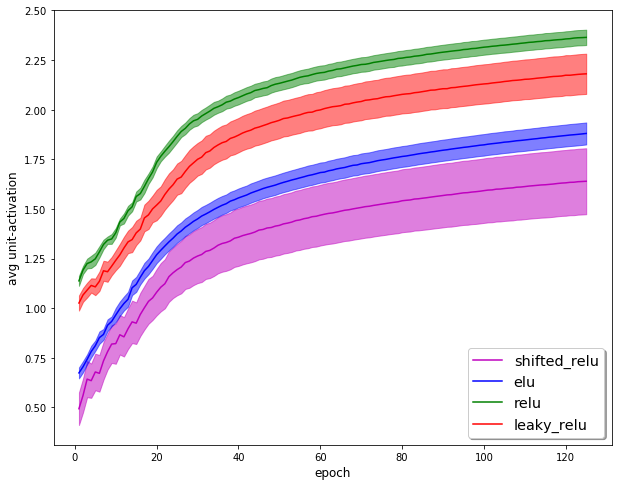

In [27]:
colors = ['m', 'b', 'g', 'r']
fig, ax = plt.subplots(figsize=(10, 8))
labels = ['shifted_relu', 'elu', 'relu', 'leaky_relu']

for i, label in enumerate(labels):
    activations_matrix = np.array([test_results[0][i]['avg_activations'], 
                            test_results[1][i]['avg_activations'], 
                            test_results[2][i]['avg_activations'],
                            test_results[3][i]['avg_activations'],
                            test_results[4][i]['avg_activations']])
    
    act_std = activations_matrix.std(0)
    
    y = np.median(activations_matrix, axis=0)
    x = np.array(range(1, len(y) + 1))
    
    ax.plot(x, y, colors[i]+'-', label=label)
    plt.fill_between(x, y - act_std / 2, y + act_std / 2, alpha=0.5, color=colors[i])
    
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.ylabel('avg unit-activation', fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.show()

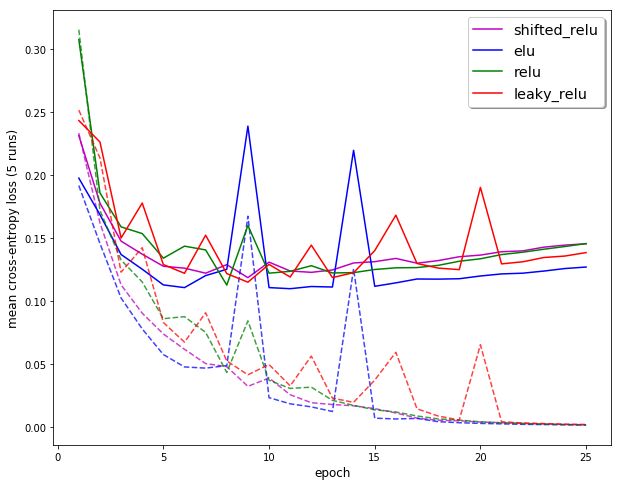

In [28]:
test_colors = ['m', 'b', 'g', 'r']
train_colors = ['m', 'b', 'g', 'r']
fig, ax = plt.subplots(figsize=(10, 8))
labels = ['shifted_relu', 'elu', 'relu', 'leaky_relu']

for i, label in enumerate(labels):
    
    test_losses = np.array([list(map(lambda x: x['test_loss'],test_results[0][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[1][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[2][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[3][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[4][i]['losses']))])
    
    train_losses = np.array([list(map(lambda x: x['train_loss'],test_results[0][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[1][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[2][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[3][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[4][i]['losses']))])
    
    train_stdev = train_losses.std(0)
    
    y_test = np.mean(test_losses, axis=0)
    y_train = np.mean(train_losses, axis=0)
    
    x = np.array(range(1, len(y_test) + 1))

    ax.plot(x[:25], y_test[:25], test_colors[i] + '-', label=label)
    ax.plot(x[:25], y_train[:25], train_colors[i] + '--', alpha=0.75)
    
#     plt.fill_between(x[:25], y_train[:25] - train_stdev[:25] / 2, y_train[:25] + train_stdev[:25] / 2, color=colors[i], alpha=.5)
    
legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
plt.ylabel('mean cross-entropy loss (5 runs)', fontsize='large')
plt.xlabel('epoch', fontsize='large')

plt.show()

In [238]:
example = nn.Linear(3,3)


In [239]:
torch.nn.init.kaiming_normal_??

In [339]:
x = torch.randn([100,28,28,28])
x.mean(),x.std()

(tensor(0.0002), tensor(1.0002))

In [340]:
example = nn.Conv2d(28,14,3)
_=torch.nn.init.kaiming_normal_(example.weight,mode='fan_out')

In [341]:
example.weight.mean(),example.weight.std()

(tensor(0.0010, grad_fn=<MeanBackward1>),
 tensor(0.1263, grad_fn=<StdBackward0>))

In [371]:
example(x).mean(),example(x).std()

(tensor(-0.0020, grad_fn=<MeanBackward1>),
 tensor(2.0036, grad_fn=<StdBackward0>))

In [343]:
out=nn.ReLU()(example(x))
out.mean(),out.std()

(tensor(0.7977, grad_fn=<MeanBackward1>),
 tensor(1.1700, grad_fn=<StdBackward0>))

In [344]:
kaimings.mean(),kaimings.std()

(tensor(0.0129, grad_fn=<MeanBackward1>),
 tensor(0.2649, grad_fn=<StdBackward0>))

In [358]:
2.0*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3))

tensor([0.0601])

In [ ]:
torch.

In [368]:
out.gather([0].flatten().shape

torch.Size([9464])

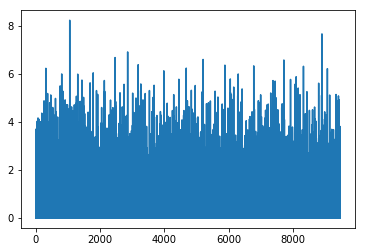

In [367]:
import matplotlib.pyplot as plt
plt.plot(out[0].flatten().detach().numpy())



In [355]:
(out>2.0*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3/500))).sum()/out.shape[0],(out>2.0*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3))).sum()/out.shape[0]

(tensor(2367), tensor(4615))

In [384]:
import scipy
from scipy.special import erfinv 
2*scipy.special.erfinv(0.25)/math.sqrt(28.0*3*3)

0.028386650711767967

In [382]:
2*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3/500))

tensor([1.3436])

In [369]:
2.0*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3/500))

tensor([1.3436])

In [346]:
2.0*torch.erfinv(torch.tensor([0.5]))/torch.sqrt(torch.tensor(28.0*3*3))

tensor([0.0601])

In [370]:
out.std()

tensor(1.1700, grad_fn=<StdBackward0>)

In [348]:
out.shape

torch.Size([100, 14, 26, 26])

In [347]:
out.shape
14*26*26/4 #(relu+half of left over)

2366.0

In [273]:
4535.0/4732

0.9583685545224007

HEY!!!!! Just go ahead and implement - 25/34 std (assuming 1). Just try to get 1/2 on each side of zero. 

Integral of the gaussian

$\displaystyle0.25=\int\limits^{\cssId{upper-bound-mathjax}{m}}_{\cssId{lower-bound-mathjax}{0}} \dfrac{1}{\sqrt{\frac{2}{n_l}}\sqrt{2{\pi}}}\mathrm{e}^{-\frac{1}{2}\left(\frac{x}{\sqrt{\frac{2}{n_l}}}\right)^2}\,\cssId{int-var-mathjax}{\mathrm{d}x}$

$\displaystyle=\int\limits^{\cssId{upper-bound-mathjax}{m}}_{\cssId{lower-bound-mathjax}{0}}\dfrac{\sqrt{n}\mathrm{e}^{-\frac{nx^2}{4}}}{2\sqrt{{\pi}}}\cssId{int-var-mathjax}{\mathrm{d}x}$

$0.25=\dfrac{\operatorname{erf}\left(\frac{m\sqrt{n}}{2}\right)}{2}$

$\dfrac{2\operatorname{ierf}\left(0.5\right)}{\sqrt{n}}=m$

In [ ]:
from scipy.special import erfinv
import math

In [ ]:
erfinv(0.5)*2/math.sqrt(3*3*3)

In [ ]:
#divide by 2 for half relu?
erfinv(0.5)*2/math.sqrt(3*3*3/2)